<a href="https://colab.research.google.com/github/python-hunglyreha/DataScience/blob/main/DL_MNIST_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.60MB/s]


####Train Data MNIST#####
Type: <class 'PIL.Image.Image'>
Size: (28, 28)
Label: 5
####Test Data MNIST#####
Type: <class 'PIL.Image.Image'>
Size: (28, 28)
Label: 7
Directory './saved_images' created successfully.


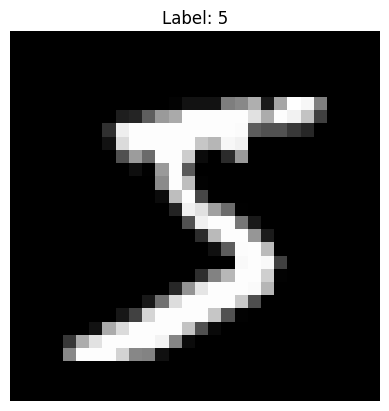

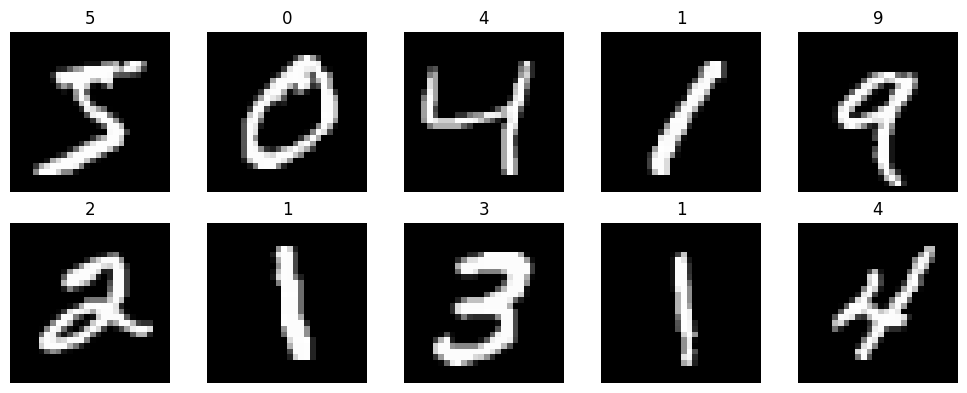

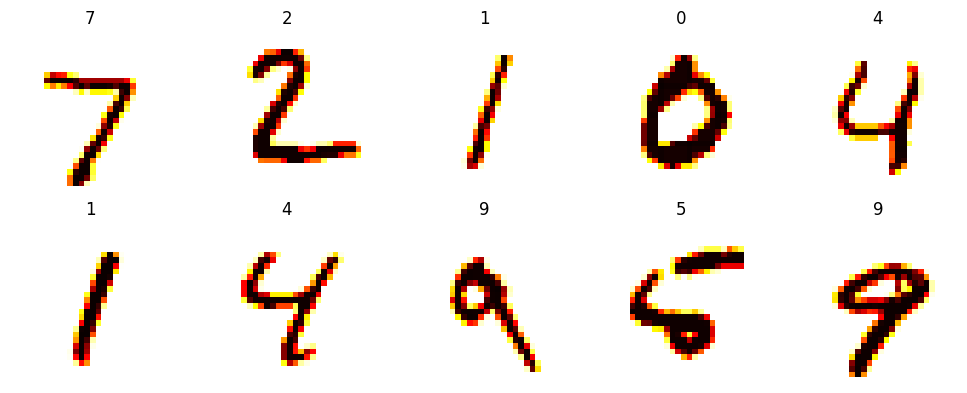

✅ Simple Shared Backbone Defined
✅ Convolutional Backbone with ReLU Defined
✅ Simple Convolutional Backbone with Adaptive Pooling Defined
✅ ConvNeXtV2 defined (224x224)
✅ EfficientNetV2 defined (224x224)
✅ Swin Transformer V2 defined (256x256)
✅ ViT defined (224x224)
✅ CoAtNet defined (224x224)
✅ UNet Like Encoder Defined
✅ ResNet-18 defined

✅ Using device: cuda

TRAINING AND EVALUATING MODELS

Training MTMShared
    Batch 0/938, Loss: 2.9914
    Batch 100/938, Loss: 0.2703
    Batch 200/938, Loss: 0.2962
    Batch 300/938, Loss: 0.0869
    Batch 400/938, Loss: 0.1904
    Batch 500/938, Loss: 0.3355
    Batch 600/938, Loss: 0.1486
    Batch 700/938, Loss: 0.2893
    Batch 800/938, Loss: 0.2972
    Batch 900/938, Loss: 0.1205
  Epoch 1/2, Avg Loss: 0.3380
    Batch 0/938, Loss: 0.1584
    Batch 100/938, Loss: 0.0470
    Batch 200/938, Loss: 0.2078
    Batch 300/938, Loss: 0.0810
    Batch 400/938, Loss: 0.1724
    Batch 500/938, Loss: 0.0656
    Batch 600/938, Loss: 0.1429
    Batch 70

<Figure size 1500x800 with 0 Axes>

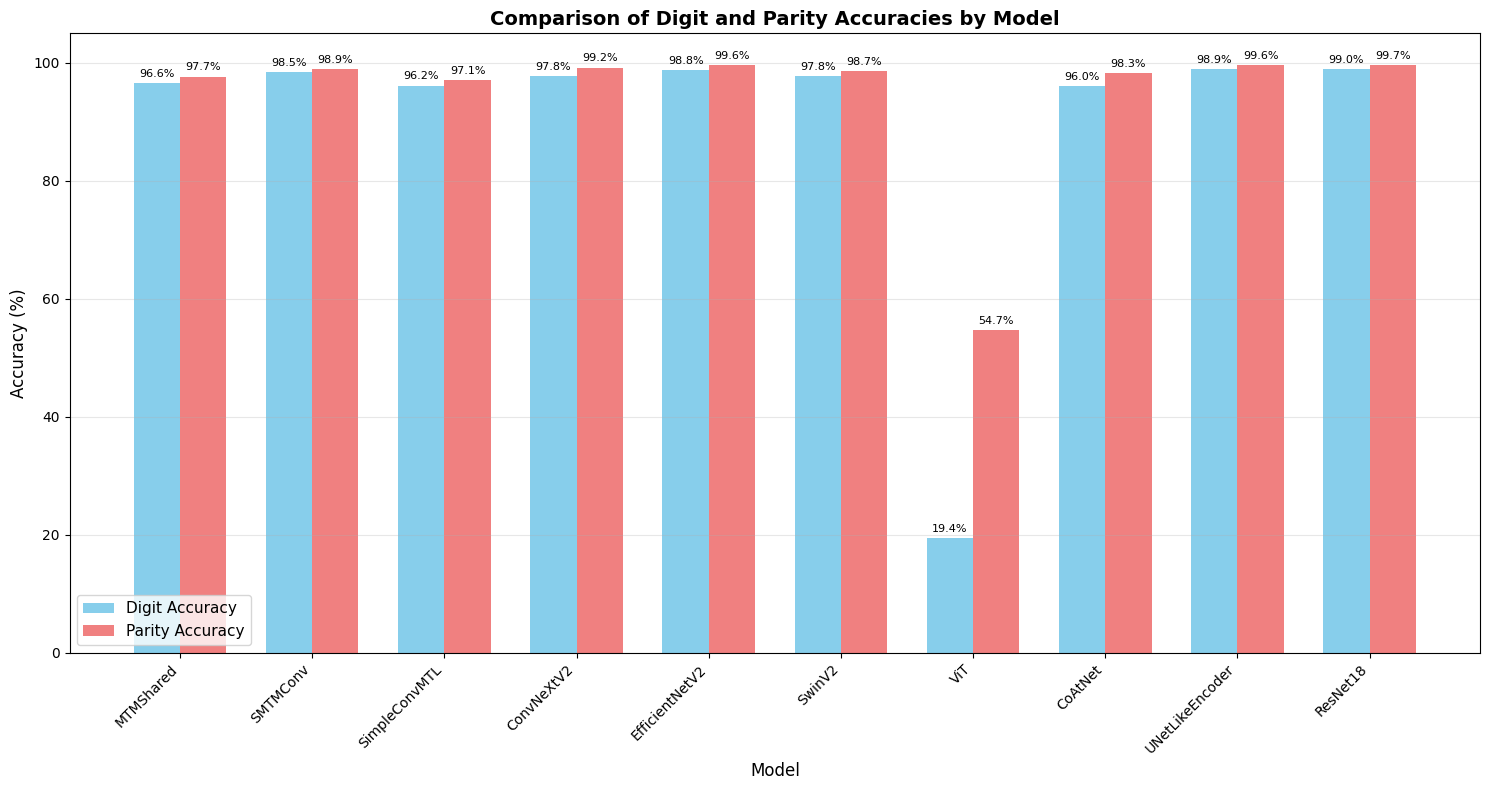

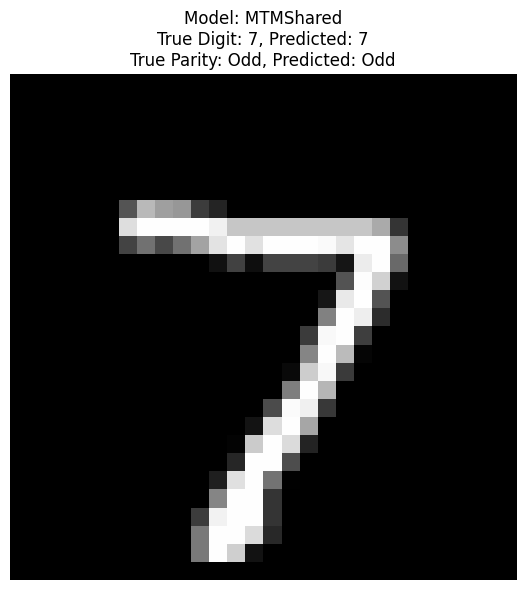


✅ Results saved to: ./saved_images

✅ Training and evaluation completed successfully!


In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import timm
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

# Loading Raw Data
# Load WITHOUT any transform → gives PIL images (0-255)
train_set_raw = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=None
)

test_set_raw = datasets.MNIST(
    root='./data',
    train=False,
    download=True
)

# Access one sample
img_tr, label_tr = train_set_raw[0]

print("####Train Data MNIST#####")
print("Type:", type(img_tr))
print("Size:", img_tr.size)
print("Label:", label_tr)

img_te, label_te = test_set_raw[0]

print("####Test Data MNIST#####")
print("Type:", type(img_te))
print("Size:", img_te.size)
print("Label:", label_te)

# Working Directory/Folder
save_dir = './saved_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory '{save_dir}' created successfully.")
else:
    print(f"Directory '{save_dir}' already exists.")

# Visualizing Raw Data
plt.imshow(img_tr, cmap='gray')
plt.title(f"Label: {label_tr}")
plt.axis('off')
plt.show()

# Show multiple train images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img_tr, lbl = train_set_raw[i]
    ax.imshow(img_tr, cmap='gray')
    ax.set_title(f"{lbl}")
    ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'train_images.png'))
plt.show()

# Show multiple test images
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img_te, lbl = test_set_raw[i]
    ax.imshow(img_te, cmap='hot_r')
    ax.set_title(f"{lbl}")
    ax.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'test_images.png'))
plt.show()
# ==================== FIXED MODEL DEFINITIONS ====================

# Simple Shared Layers Backbone (for 28x28 images)
class MTMShared(nn.Module):
    def __init__(self):
        super(MTMShared, self).__init__()
        self.shared = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.digit_head = nn.Linear(128, 10)
        self.parity_head = nn.Linear(128, 2)

    def forward(self, x):
        features = self.shared(x)
        return self.digit_head(features), self.parity_head(features)

print("✅ Simple Shared Backbone Defined")

# Simple Convolutional Backbone 1
class SMTMConv(nn.Module):
    def __init__(self, in_channels=1, num_classes_digit=10, num_classes_parity=2):
        super(SMTMConv, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU()
        )
        self.digit_head = nn.Linear(128, num_classes_digit)
        self.parity_head = nn.Linear(128, num_classes_parity)

    def forward(self, x):
        features = self.backbone(x)
        return self.digit_head(features), self.parity_head(features)

print("✅ Convolutional Backbone with ReLU Defined")

# Simple Convolution Backbone 2 (with Adaptive Pooling)
class SimpleConvMTL(nn.Module):
    def __init__(self, in_channels=1, num_classes_digit=10, num_classes_parity=2):
        super(SimpleConvMTL, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()
        )
        feat_dim = 128
        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        feat = self.backbone(x)
        return self.digit_head(feat), self.aux_head(feat)

print("✅ Simple Convolutional Backbone with Adaptive Pooling Defined")

# FIXED: ConvNeXt V2 - Using correct input size (224x224)
class ConvNeXtV2_MTL(nn.Module):
    def __init__(self, num_classes_digit=10, num_classes_parity=2):
        super(ConvNeXtV2_MTL, self).__init__()
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        self.backbone = timm.create_model('convnextv2_tiny', pretrained=False, in_chans=1, num_classes=0)
        feat_dim = 768
        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        x = self.resize(x)
        features = self.backbone(x)
        return self.digit_head(features), self.aux_head(features)

print("✅ ConvNeXtV2 defined (224x224)")

# FIXED: EfficientNetV2 - Using correct input size (224x224 for tiny/small)
class EfficientNetV2_MTL(nn.Module):
    def __init__(self, variant='efficientnetv2_s', num_classes_digit=10, num_classes_parity=2):
        super(EfficientNetV2_MTL, self).__init__()
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        self.backbone = timm.create_model(variant, pretrained=False, in_chans=1, num_classes=0)

        # Get correct feature dimension based on variant
        if 's' in variant:
            feat_dim = 1280
        elif 'm' in variant:
            feat_dim = 1280
        elif 'l' in variant:
            feat_dim = 1408
        else:
            feat_dim = 1280

        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        x = self.resize(x)
        features = self.backbone(x)
        return self.digit_head(features), self.aux_head(features)

print("✅ EfficientNetV2 defined (224x224)")

# FIXED: Swin Transformer V2 - Using correct input size (256x256)
class SwinV2_MTL(nn.Module):
    def __init__(self, variant='swinv2_tiny_window8_256', num_classes_digit=10, num_classes_parity=2):
        super(SwinV2_MTL, self).__init__()
        self.resize = nn.Upsample(size=(256, 256), mode='bilinear', align_corners=False)
        self.backbone = timm.create_model(variant, pretrained=False, in_chans=1, num_classes=0)
        feat_dim = 768
        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        x = self.resize(x)
        features = self.backbone(x)
        return self.digit_head(features), self.aux_head(features)

print("✅ Swin Transformer V2 defined (256x256)")

# FIXED: ViT - Using correct input size (224x224)
class ViT_MTL(nn.Module):
    def __init__(self, variant='vit_base_patch16_224', num_classes_digit=10, num_classes_parity=2):
        super(ViT_MTL, self).__init__()
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        self.backbone = timm.create_model(variant, pretrained=False, in_chans=1, num_classes=0)
        feat_dim = self.backbone.num_features
        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        x = self.resize(x)
        features = self.backbone(x)
        return self.digit_head(features), self.aux_head(features)

print("✅ ViT defined (224x224)")

# FIXED: CoAtNet - Using correct input size (224x224)
class CoAtNet_MTL(nn.Module):
    def __init__(self, variant='coatnet_0_rw_224', num_classes_digit=10, num_classes_parity=2):
        super(CoAtNet_MTL, self).__init__()
        self.resize = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
        self.backbone = timm.create_model(variant, pretrained=False, in_chans=1, num_classes=0)
        feat_dim = self.backbone.num_features
        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        x = self.resize(x)
        features = self.backbone(x)
        return self.digit_head(features), self.aux_head(features)

print("✅ CoAtNet defined (224x224)")

# U-Net Style Encoder
class UNetLikeEncoderMTL(nn.Module):
    def __init__(self, in_channels=1, num_classes_digit=10, num_classes_parity=2):
        super(UNetLikeEncoderMTL, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU()
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        feat_dim = 512
        self.digit_head = nn.Linear(feat_dim, num_classes_digit)
        self.aux_head = nn.Linear(feat_dim, num_classes_parity)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        bott = self.bottleneck(p3)
        feat = self.flatten(self.global_pool(bott))
        return self.digit_head(feat), self.aux_head(feat)

print("✅ UNet Like Encoder Defined")

# ResNet Implementation
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes_digit=10, num_classes_parity=2):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_features = nn.Linear(512 * block.expansion, 512)

        self.head_digit = nn.Linear(512, num_classes_digit)
        self.head_parity = nn.Linear(512, num_classes_parity)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc_features(x)
        features = F.relu(features)

        return self.head_digit(features), self.head_parity(features)

def resnet18_mtl(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

print("✅ ResNet-18 defined")

# ==================== DATA PREPARATION ====================

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def get_parity_labels(labels):
    return (labels % 2).long()

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

# ==================== TRAINING SETUP ====================

# Define all models with corrected names
models = OrderedDict([
    ('MTMShared', MTMShared()),
    ('SMTMConv', SMTMConv()),
    ('SimpleConvMTL', SimpleConvMTL()),
    ('ConvNeXtV2', ConvNeXtV2_MTL()),
    ('EfficientNetV2', EfficientNetV2_MTL()),
    ('SwinV2', SwinV2_MTL()),
    ('ViT', ViT_MTL()),
    ('CoAtNet', CoAtNet_MTL()),
    ('UNetLikeEncoder', UNetLikeEncoderMTL()),
    ('ResNet18', resnet18_mtl())
])

# Training function
def train_model(model, train_loader, num_epochs=2):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (images, digit_labels) in enumerate(train_loader):
            images, digit_labels = images.to(device), digit_labels.to(device)
            parity_labels = get_parity_labels(digit_labels)

            optimizer.zero_grad()
            digit_pred, parity_pred = model(images)

            loss_digit = criterion(digit_pred, digit_labels)
            loss_parity = criterion(parity_pred, parity_labels)
            loss = loss_digit + loss_parity

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 100 == 0:
                print(f"    Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

        print(f"  Epoch {epoch+1}/{num_epochs}, Avg Loss: {total_loss / len(train_loader):.4f}")

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct_digit, correct_parity, total = 0, 0, 0

    with torch.no_grad():
        for images, digit_labels in test_loader:
            images, digit_labels = images.to(device), digit_labels.to(device)
            parity_labels = get_parity_labels(digit_labels)

            digit_pred, parity_pred = model(images)

            correct_digit += (digit_pred.argmax(1) == digit_labels).sum().item()
            correct_parity += (parity_pred.argmax(1) == parity_labels).sum().item()
            total += digit_labels.size(0)

    digit_accuracy = 100.0 * correct_digit / total
    parity_accuracy = 100.0 * correct_parity / total

    return digit_accuracy, parity_accuracy

# ==================== TRAINING LOOP ====================

print("\n" + "="*60)
print("TRAINING AND EVALUATING MODELS")
print("="*60)

model_names = []
digit_accuracies = []
parity_accuracies = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}")
    print(f"{'='*50}")

    try:
        # Train model
        trained_model = train_model(model, train_loader, num_epochs=2)

        # Evaluate model
        digit_acc, parity_acc = evaluate_model(trained_model, test_loader)

        print(f"\n✅ Results for {name}:")
        print(f"   Digit Accuracy: {digit_acc:.2f}%")
        print(f"   Parity Accuracy: {parity_acc:.2f}%")

        # Store results
        model_names.append(name)
        digit_accuracies.append(digit_acc)
        parity_accuracies.append(parity_acc)

    except Exception as e:
        print(f"❌ Error training {name}: {str(e)}")
        model_names.append(name)
        digit_accuracies.append(0.0)
        parity_accuracies.append(0.0)

# ==================== RESULTS VISUALIZATION ====================

# Create results DataFrame
data = {
    'Model': model_names,
    'Digit Accuracy': digit_accuracies,
    'Parity Accuracy': parity_accuracies
}

df_accuracies = pd.DataFrame(data)
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(df_accuracies.to_string(index=False))

# Create comparison bar chart
if len(model_names) > 0:
    plt.figure(figsize=(15, 8))

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(15, 8))
    rects1 = ax.bar(x - width/2, digit_accuracies, width, label='Digit Accuracy', color='skyblue')
    rects2 = ax.bar(x + width/2, parity_accuracies, width, label='Parity Accuracy', color='lightcoral')

    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Comparison of Digit and Parity Accuracies by Model', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 105)
    ax.grid(True, axis='y', alpha=0.3)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1f}%',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'model_accuracy_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

# Visualize sample prediction
if len(models) > 0:
    first_model_name = list(models.keys())[0]
    first_model = models[first_model_name].to(device)

    images, digit_labels = next(iter(test_loader))
    images, digit_labels = images.to(device), digit_labels.to(device)

    first_model.eval()
    with torch.no_grad():
        digit_pred, parity_pred = first_model(images)

    sample_img = images[0].cpu().squeeze().numpy()
    plt.figure(figsize=(8, 6))
    plt.imshow(sample_img, cmap='gray')

    true_digit = digit_labels[0].item()
    pred_digit = digit_pred[0].argmax().item()
    true_parity = 'Even' if true_digit % 2 == 0 else 'Odd'
    pred_parity = 'Even' if parity_pred[0].argmax().item() == 0 else 'Odd'

    plt.title(f"Model: {first_model_name}\n"
              f"True Digit: {true_digit}, Predicted: {pred_digit}\n"
              f"True Parity: {true_parity}, Predicted: {pred_parity}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'sample_prediction.png'))
    plt.show()

print(f"\n✅ Results saved to: {save_dir}")
print("\n✅ Training and evaluation completed successfully!")


DETAILED EVALUATION METRICS AND PLOTS

GENERATING COMPREHENSIVE EVALUATION PLOTS

PERFORMANCE SUMMARY TABLE
          Model Digit Acc (%) Parity Acc (%) Avg Performance
      MTMShared         96.59          97.66           97.12
       SMTMConv         98.50          98.87           98.69
  SimpleConvMTL         96.15          97.09           96.62
     ConvNeXtV2         97.80          99.19           98.50
 EfficientNetV2         98.83          99.56           99.19
         SwinV2         97.79          98.65           98.22
            ViT         19.39          54.68           37.03
        CoAtNet         96.02          98.29           97.16
UNetLikeEncoder         98.89          99.57           99.23
       ResNet18         98.97          99.66           99.31

KEY INSIGHTS
📊 Average Digit Accuracy across all models: 89.89%
📊 Average Parity Accuracy across all models: 94.32%
🏆 Best Digit Accuracy: 98.97% (ResNet18)
🏆 Best Parity Accuracy: 99.66% (ResNet18)
⚖️ Most Balanced Mod

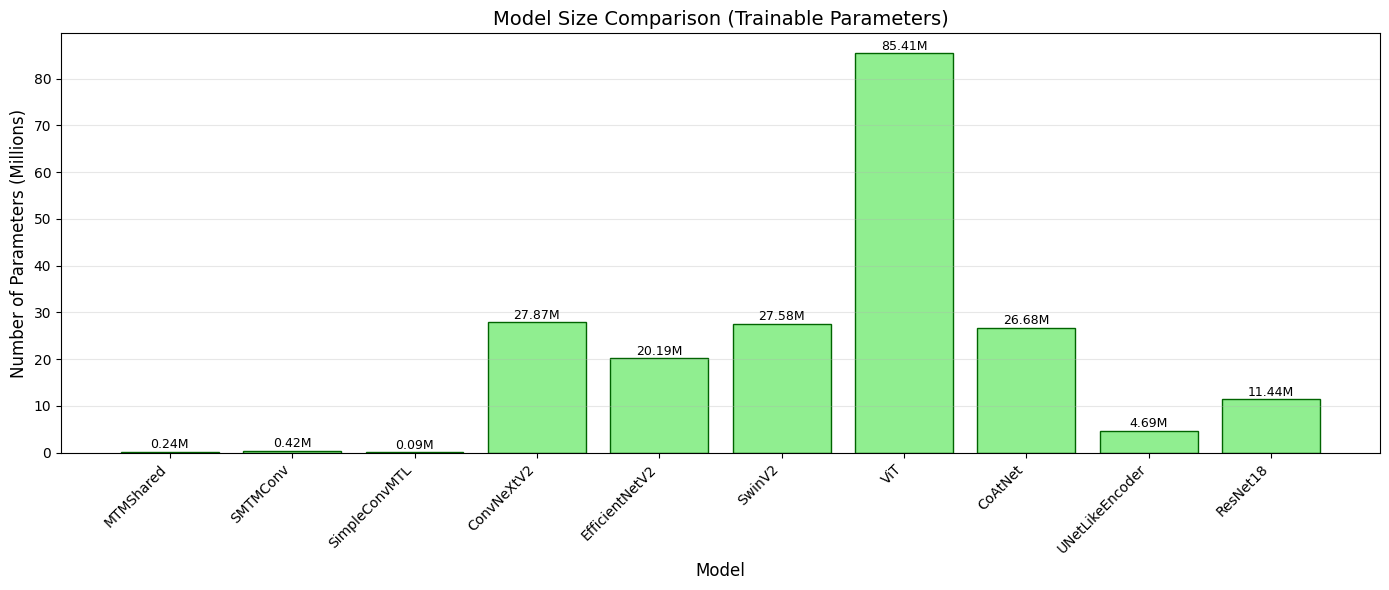

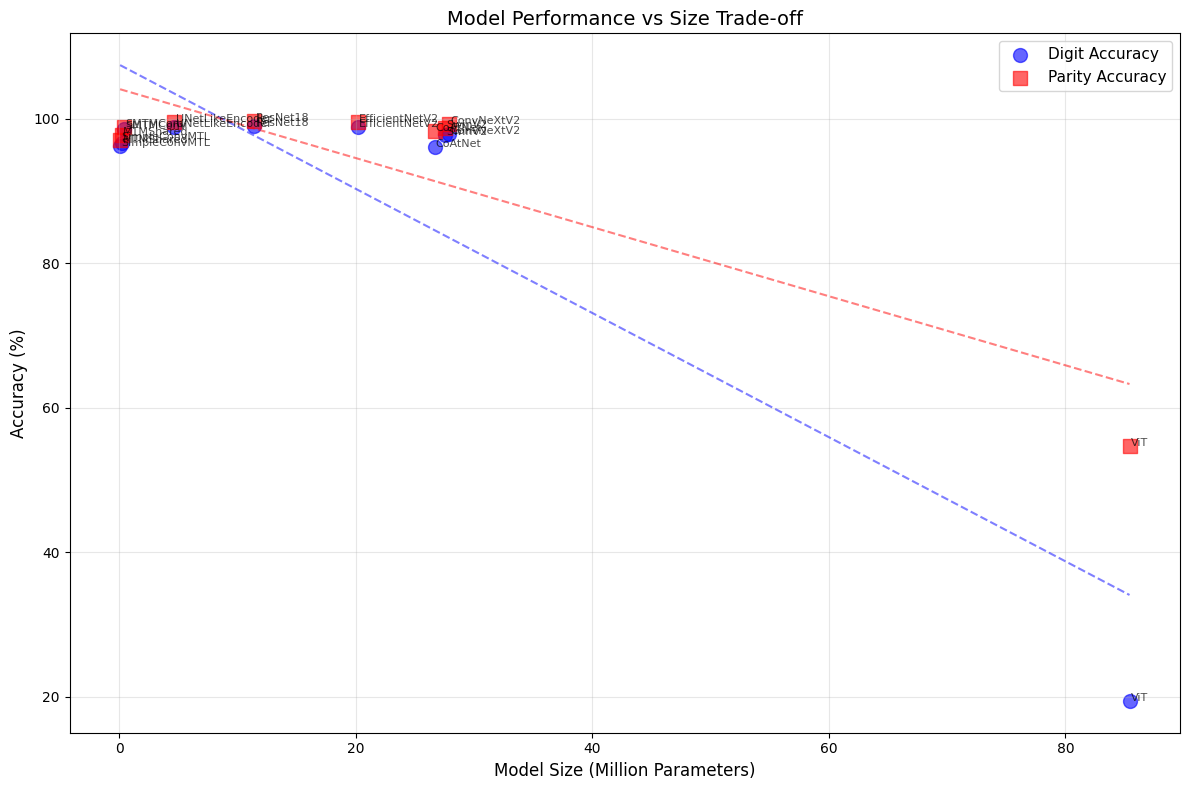

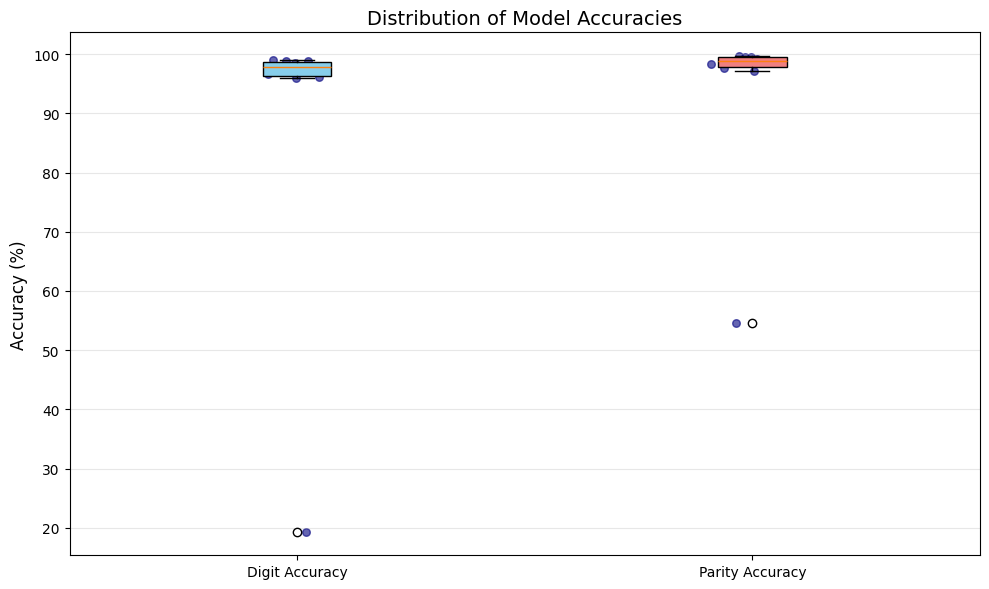

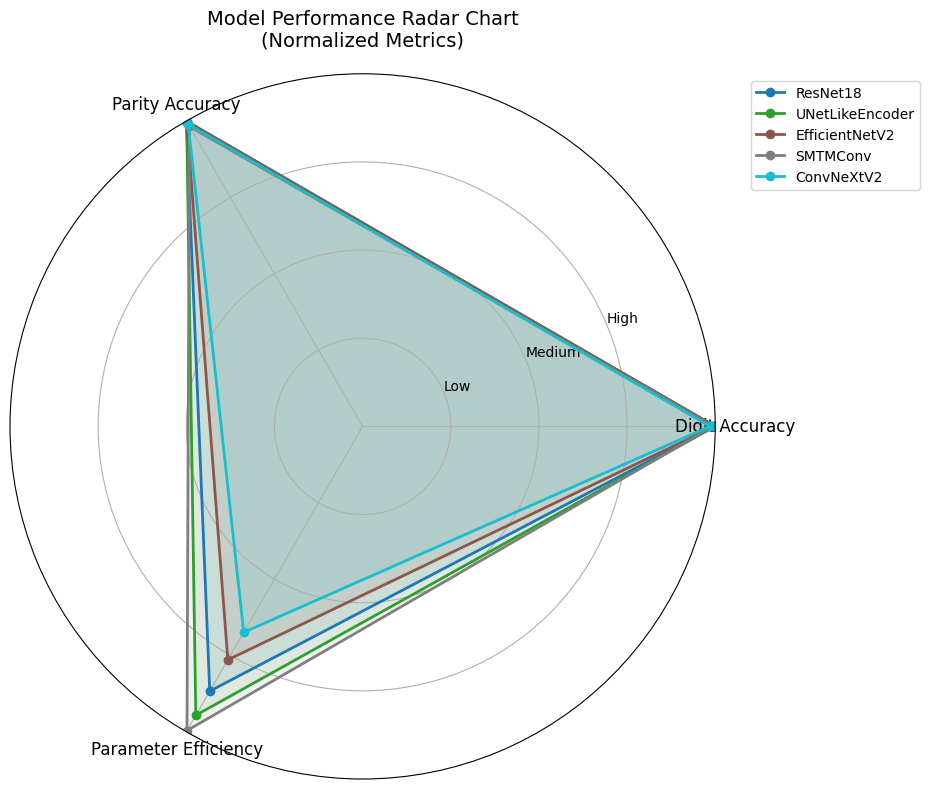


GENERATING DETAILED PLOTS FOR EACH MODEL

📊 Analyzing MTMShared...


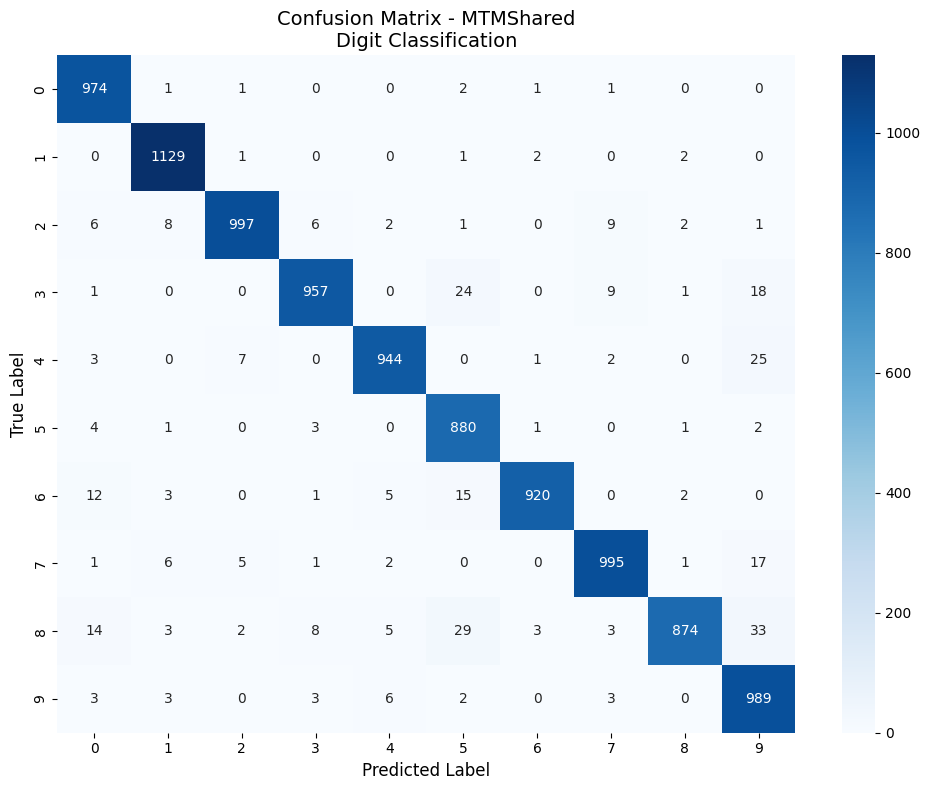

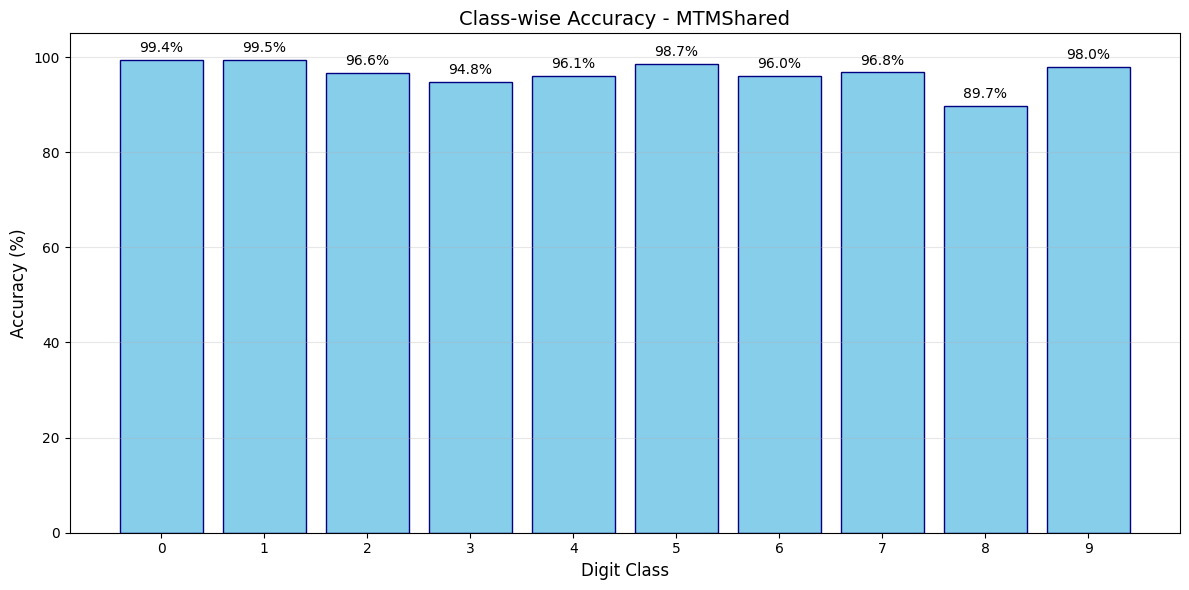

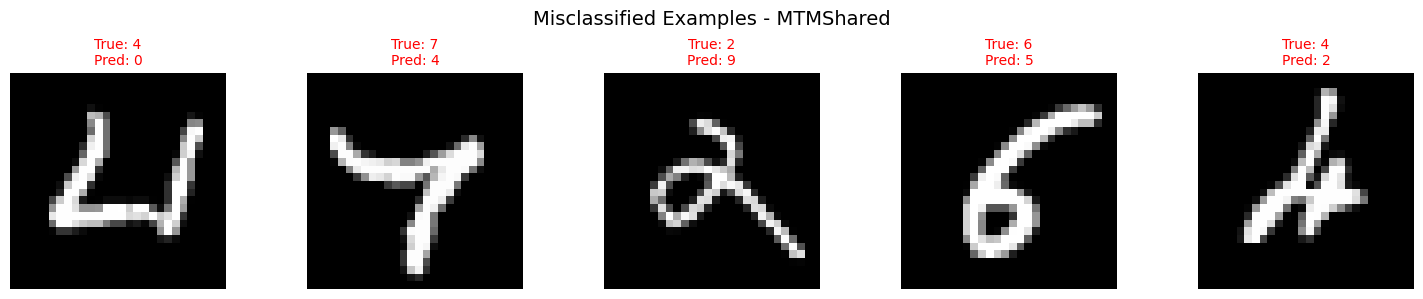


📊 Analyzing SMTMConv...


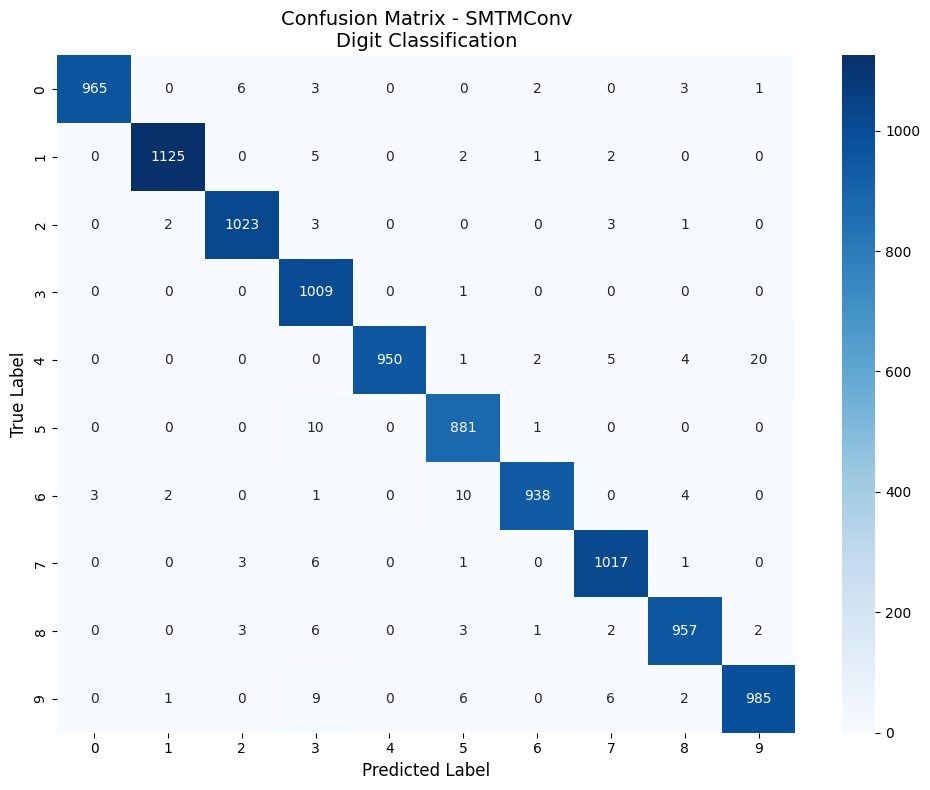

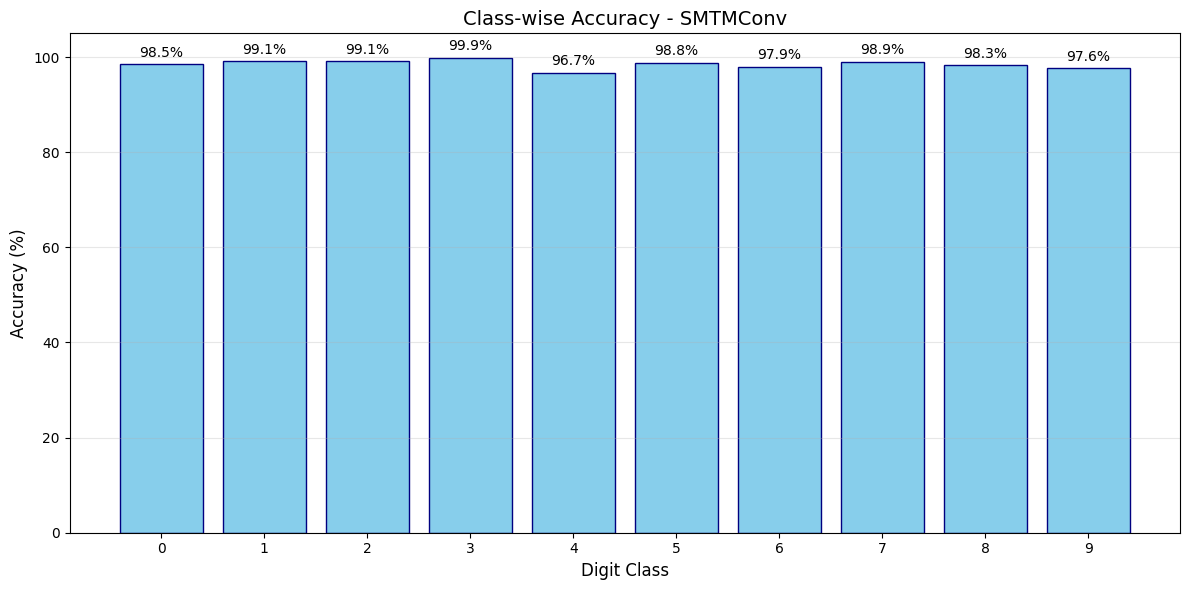

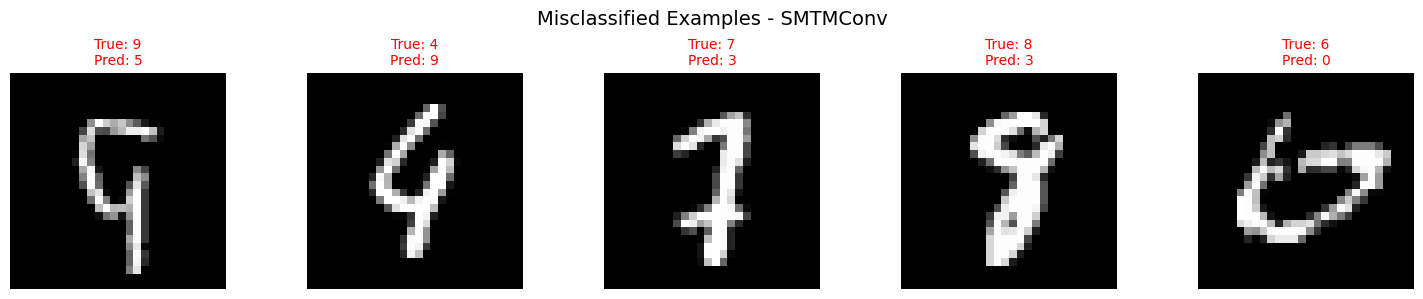


📊 Analyzing SimpleConvMTL...


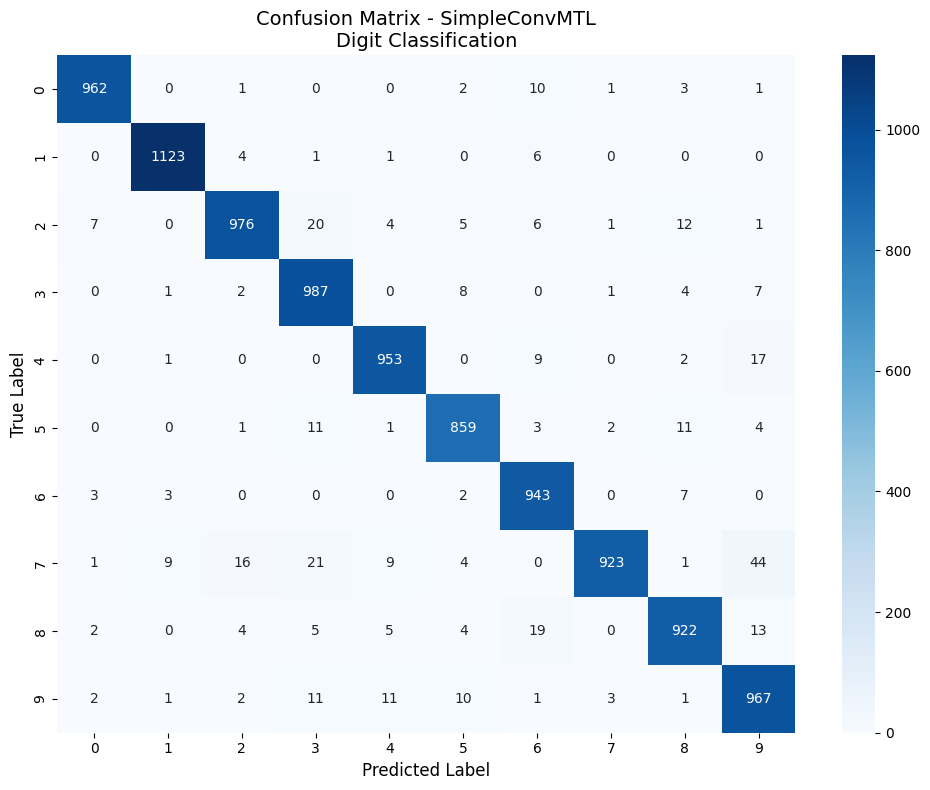

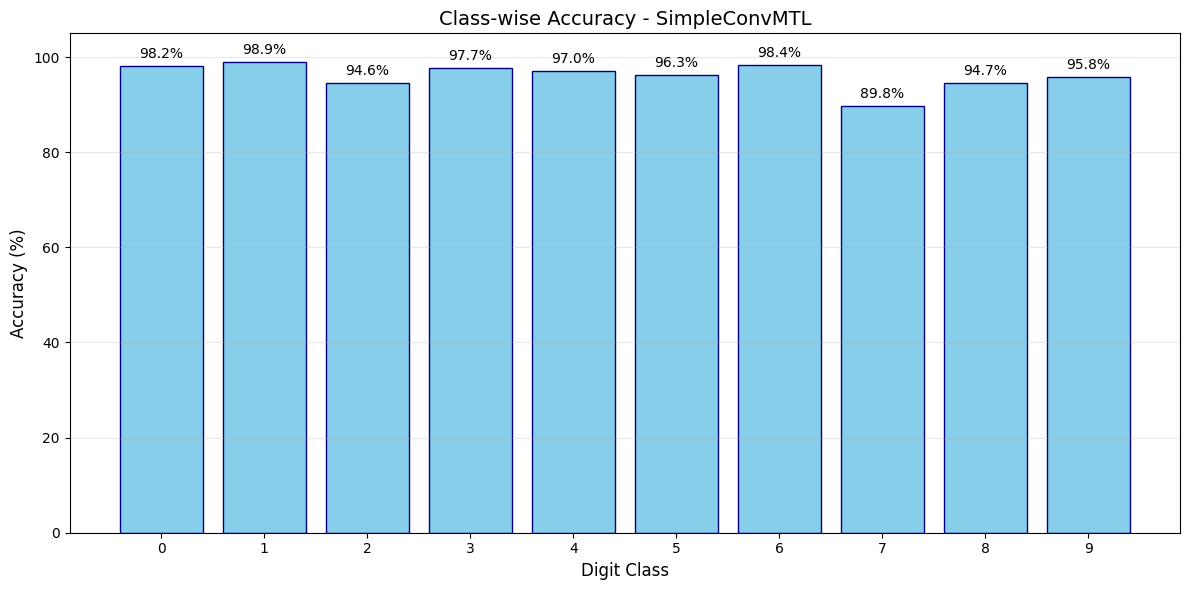

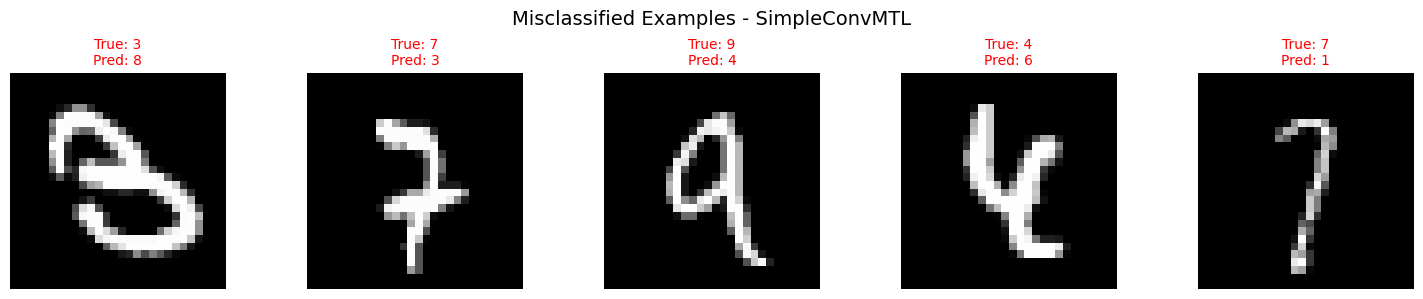


📊 Analyzing ConvNeXtV2...


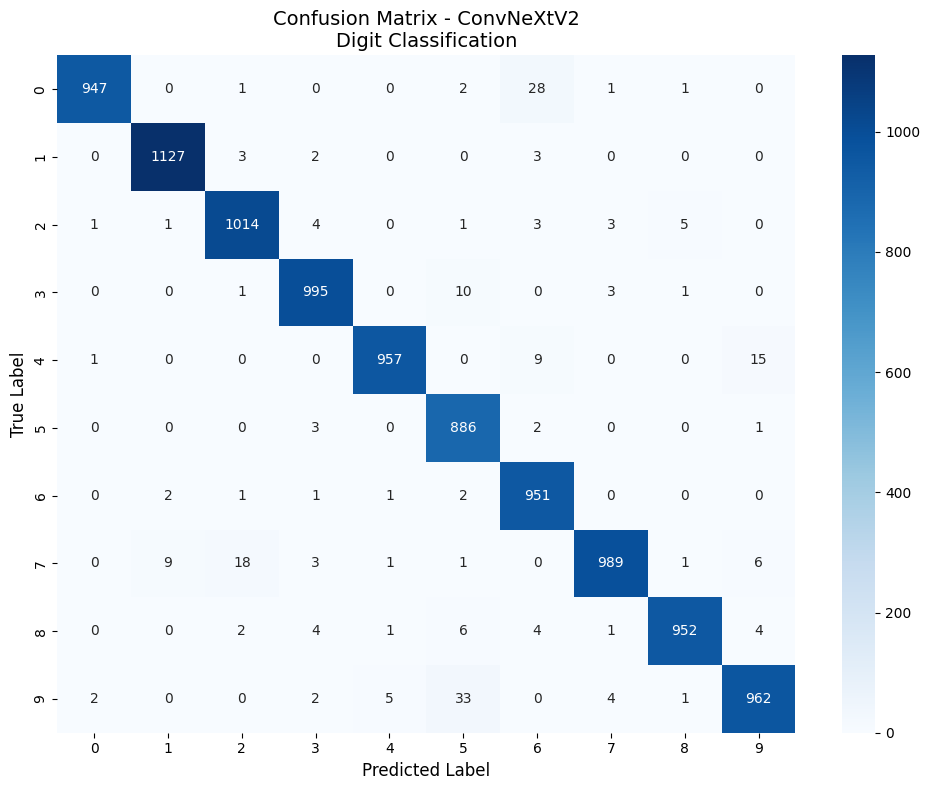

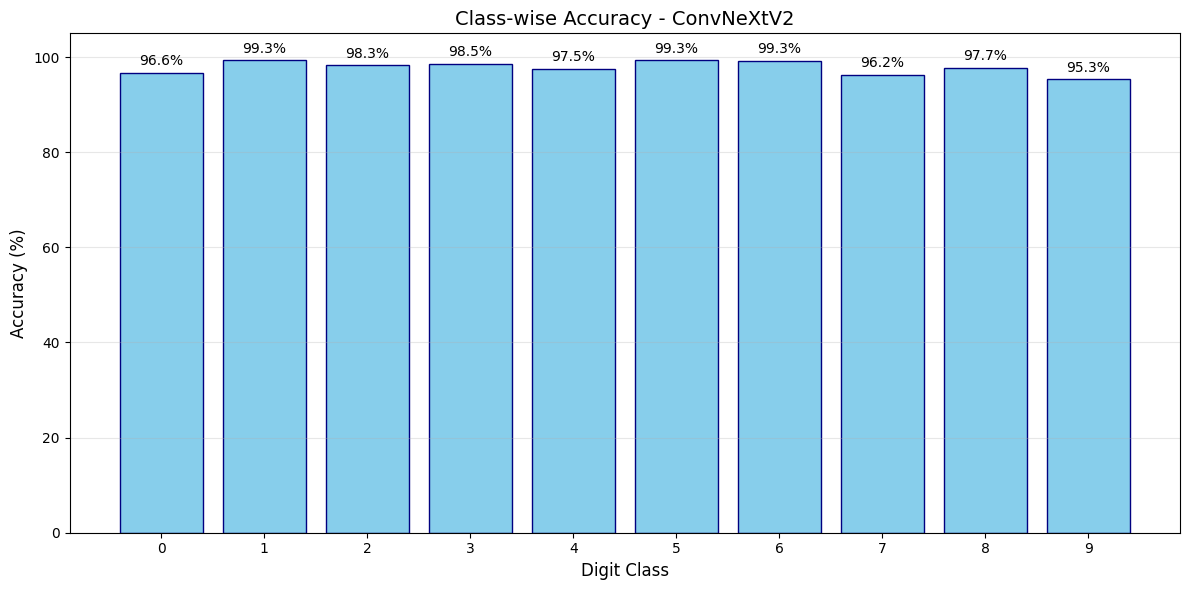

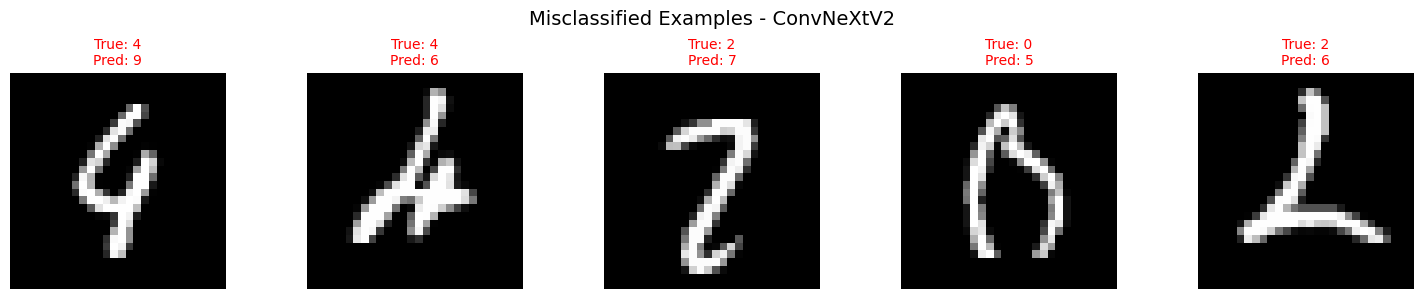


📊 Analyzing EfficientNetV2...


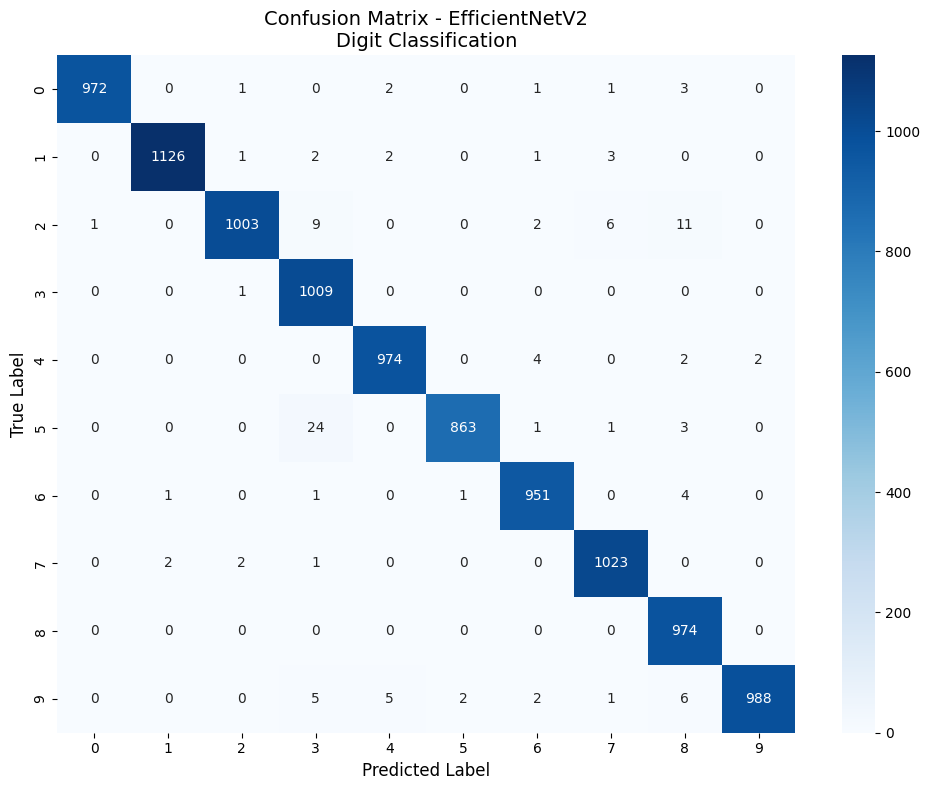

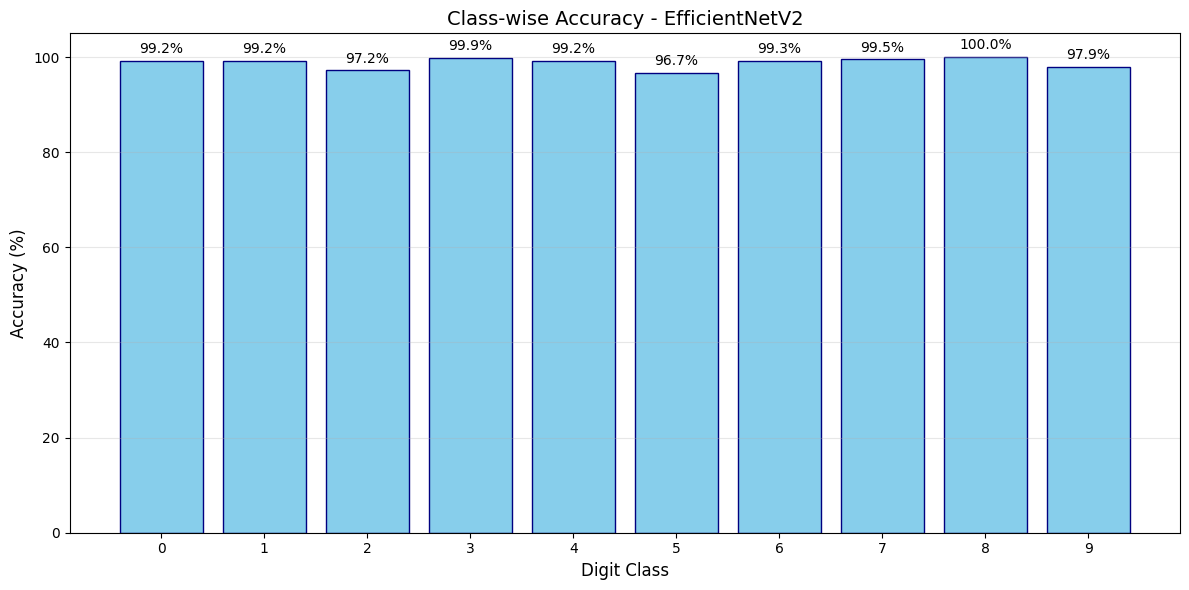

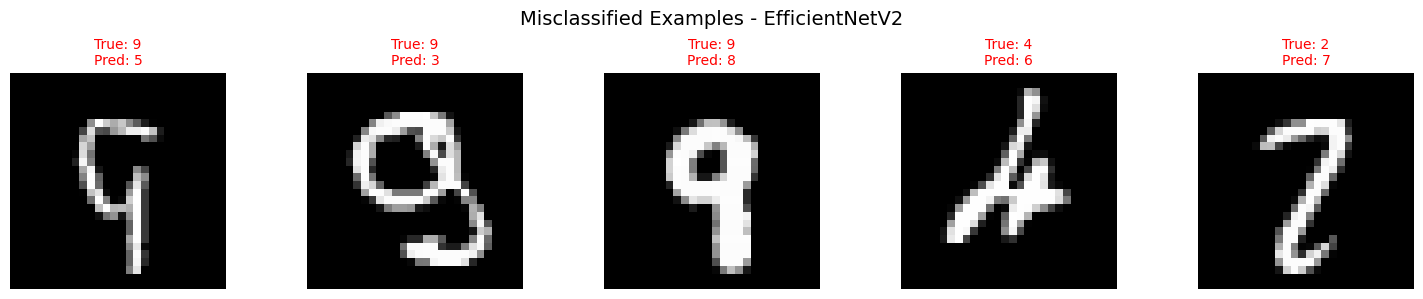


📊 Analyzing SwinV2...


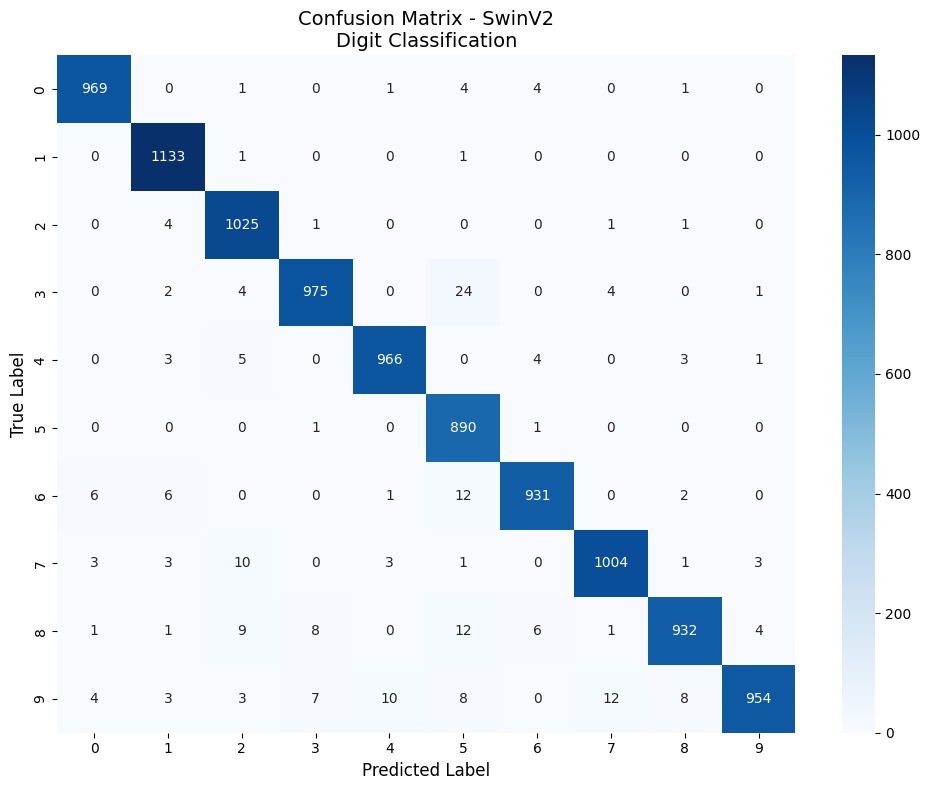

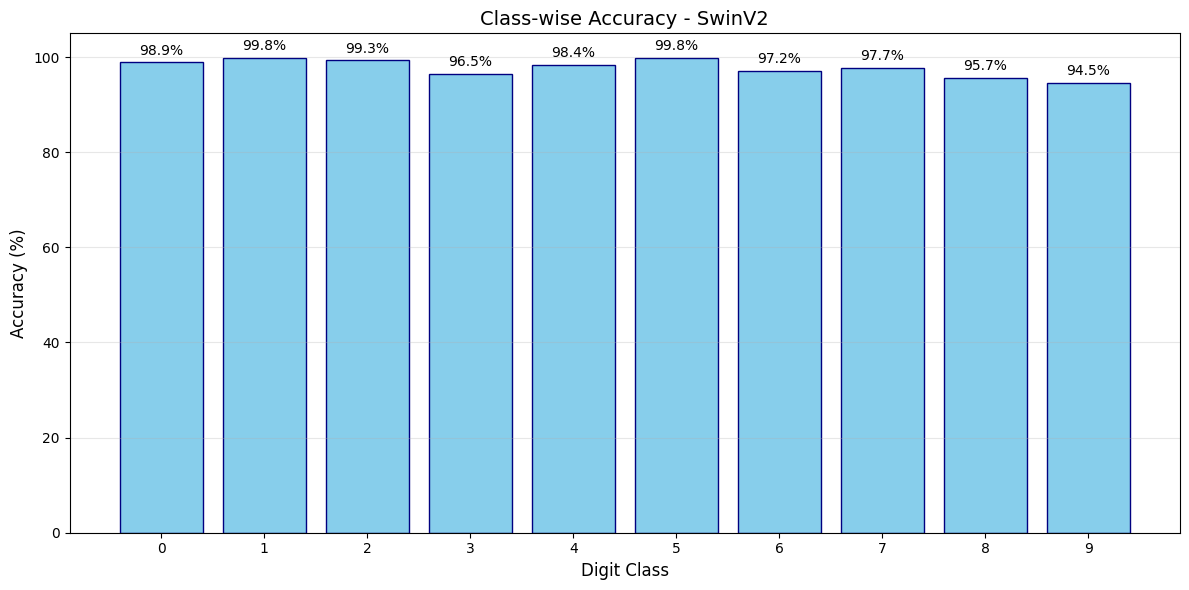

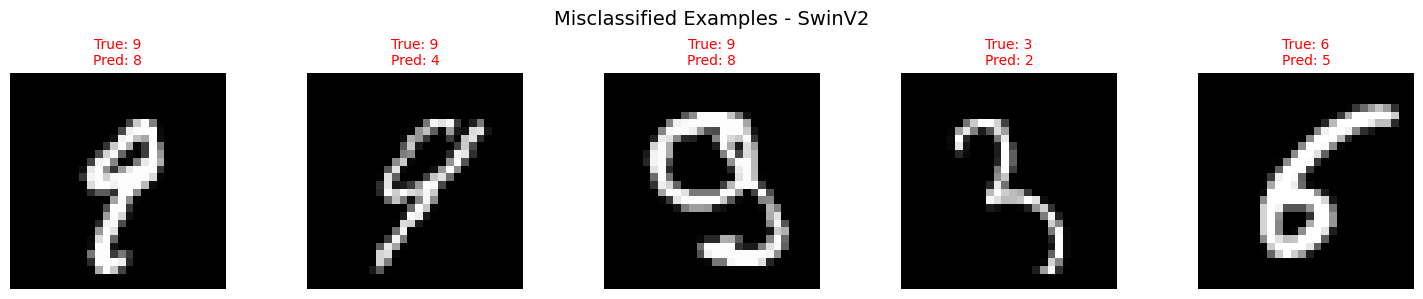


📊 Analyzing ViT...


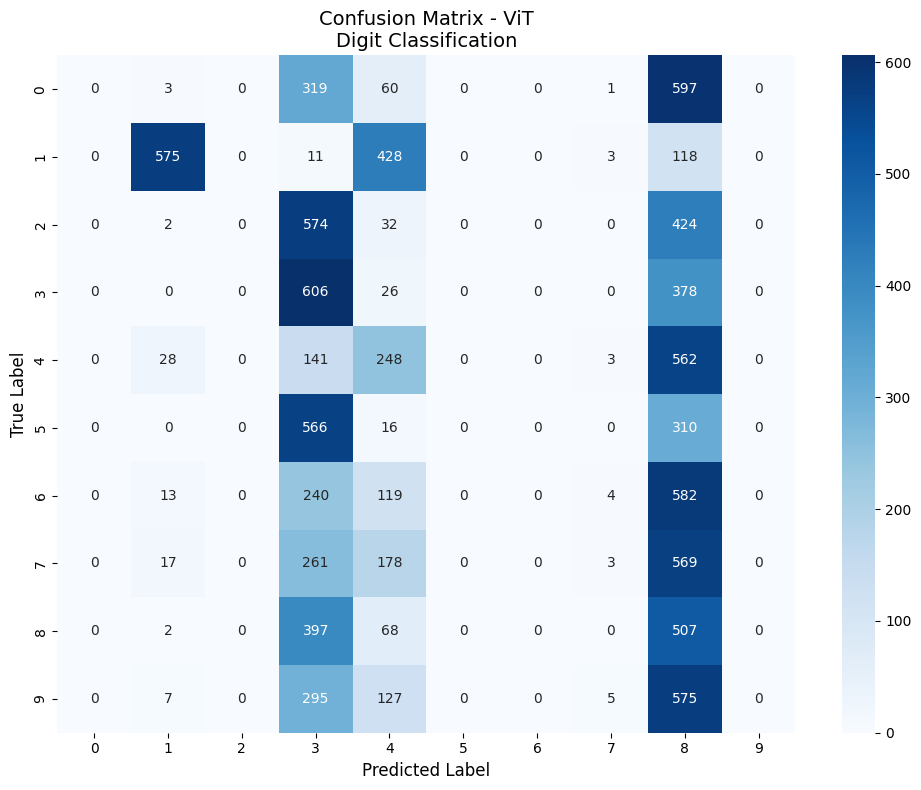

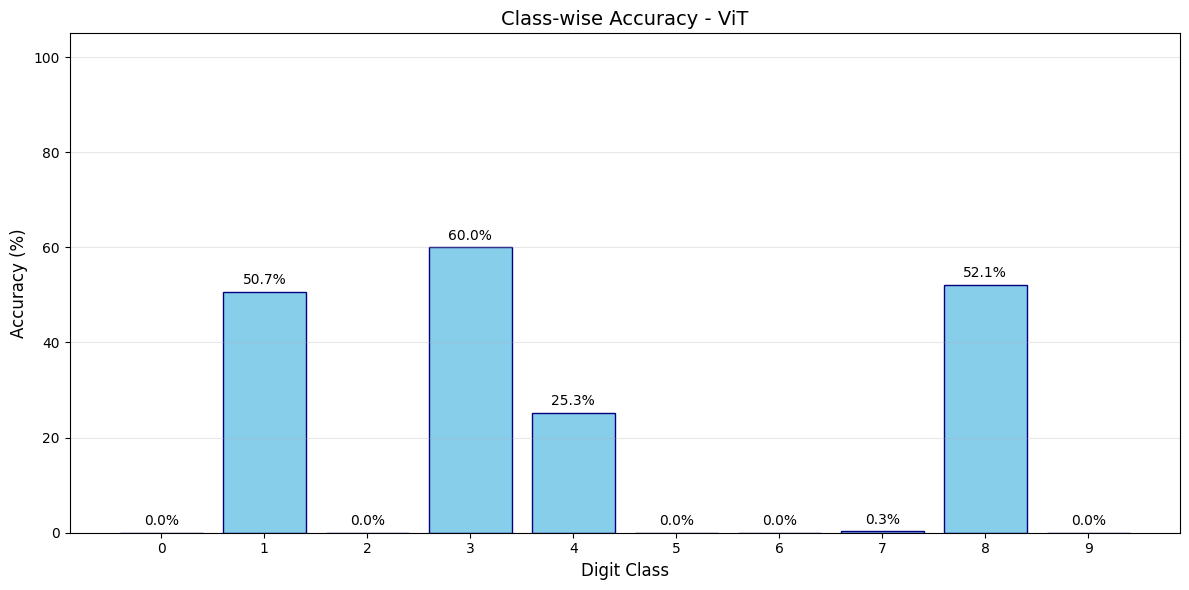

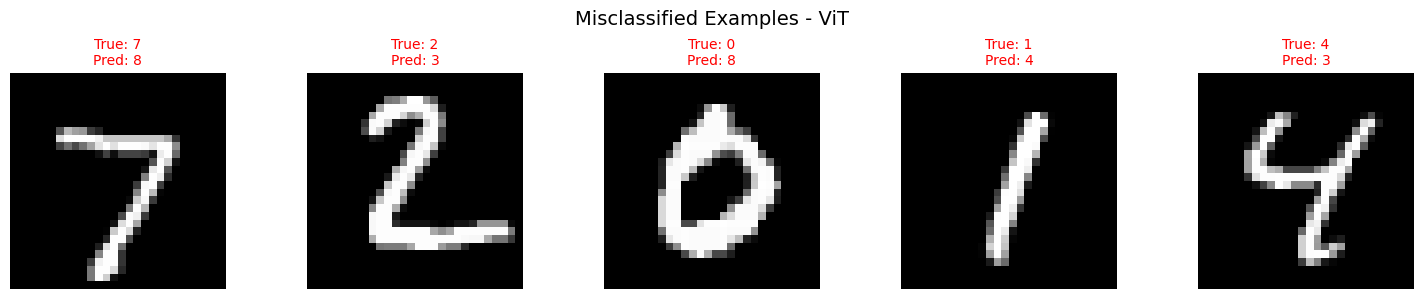


📊 Analyzing CoAtNet...


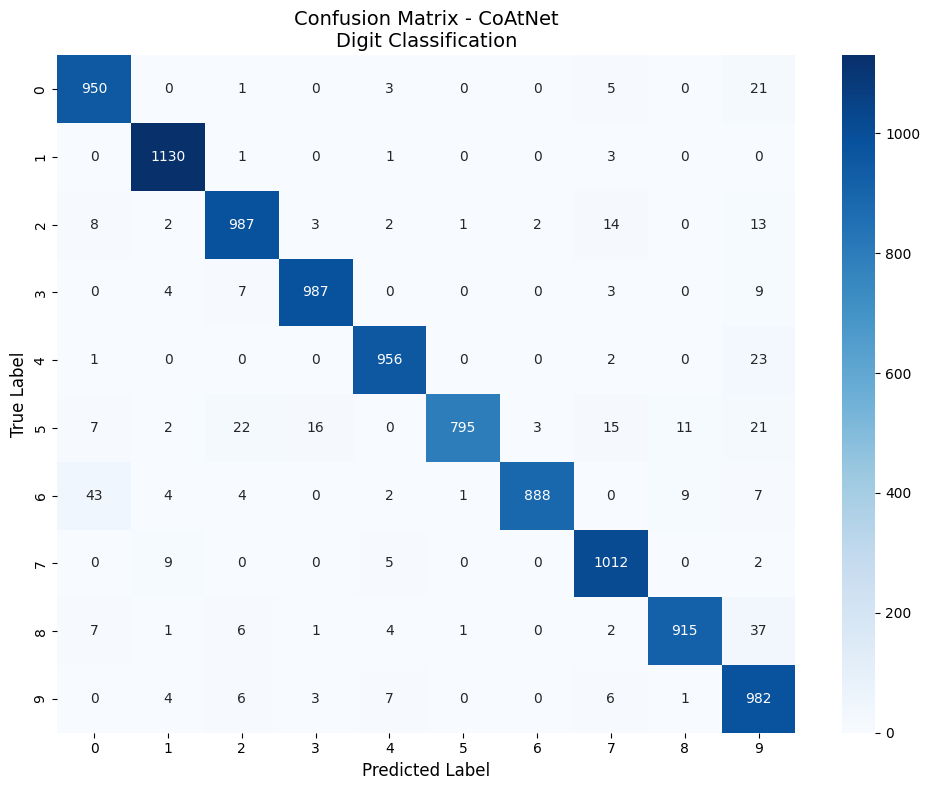

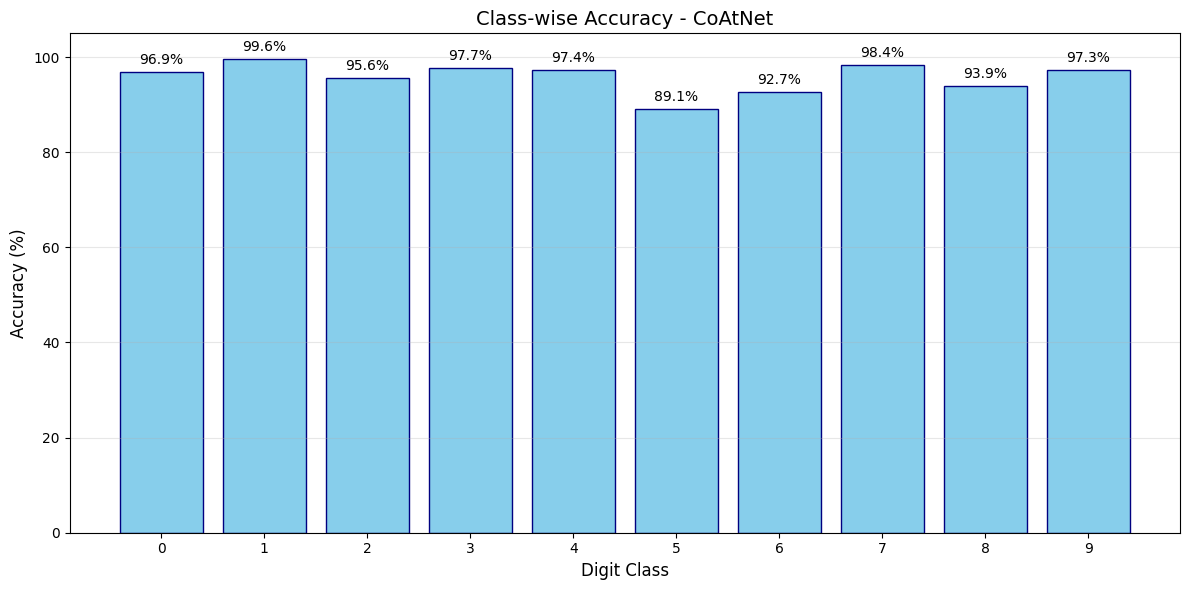

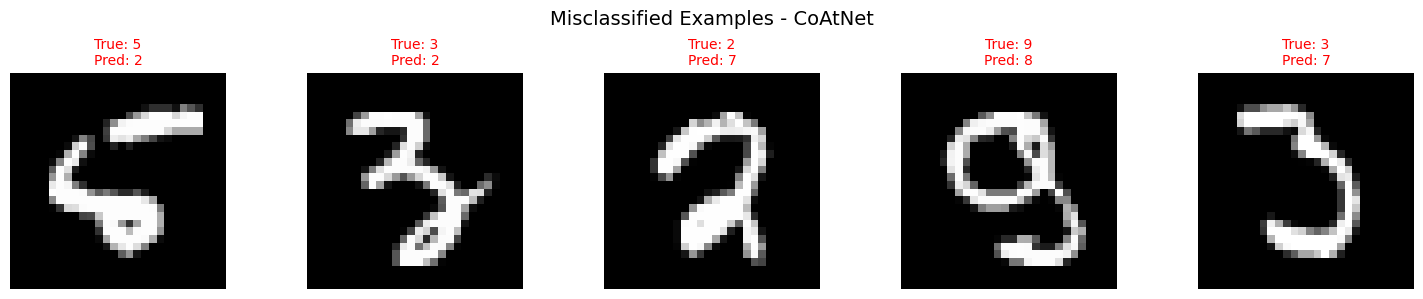


📊 Analyzing UNetLikeEncoder...


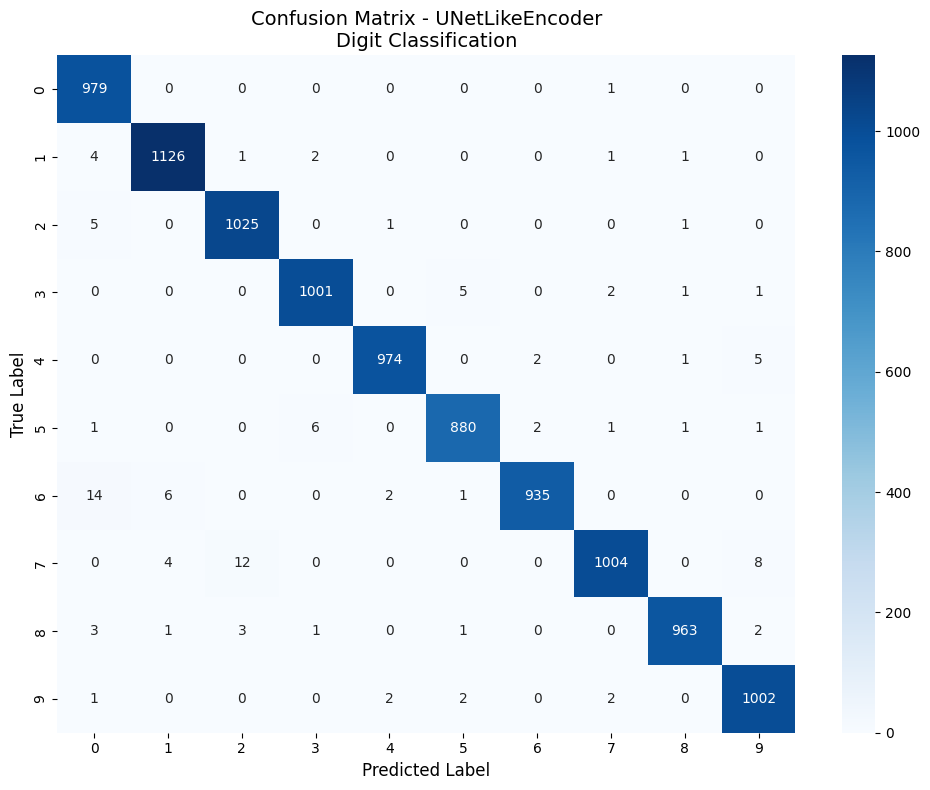

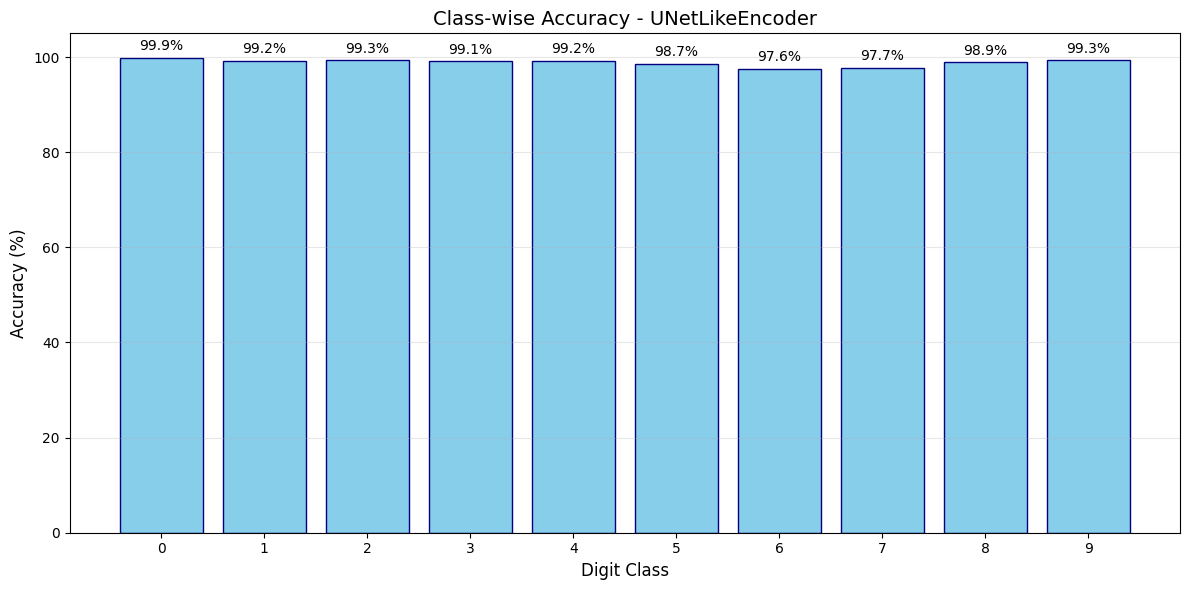

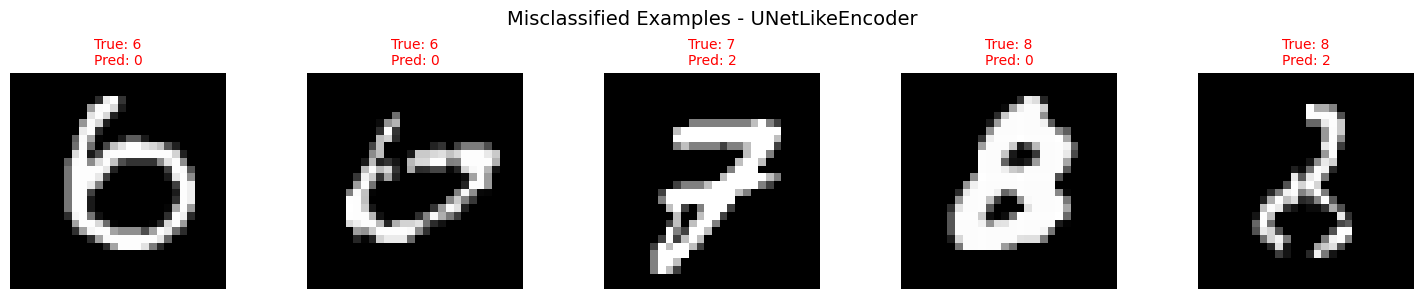


📊 Analyzing ResNet18...


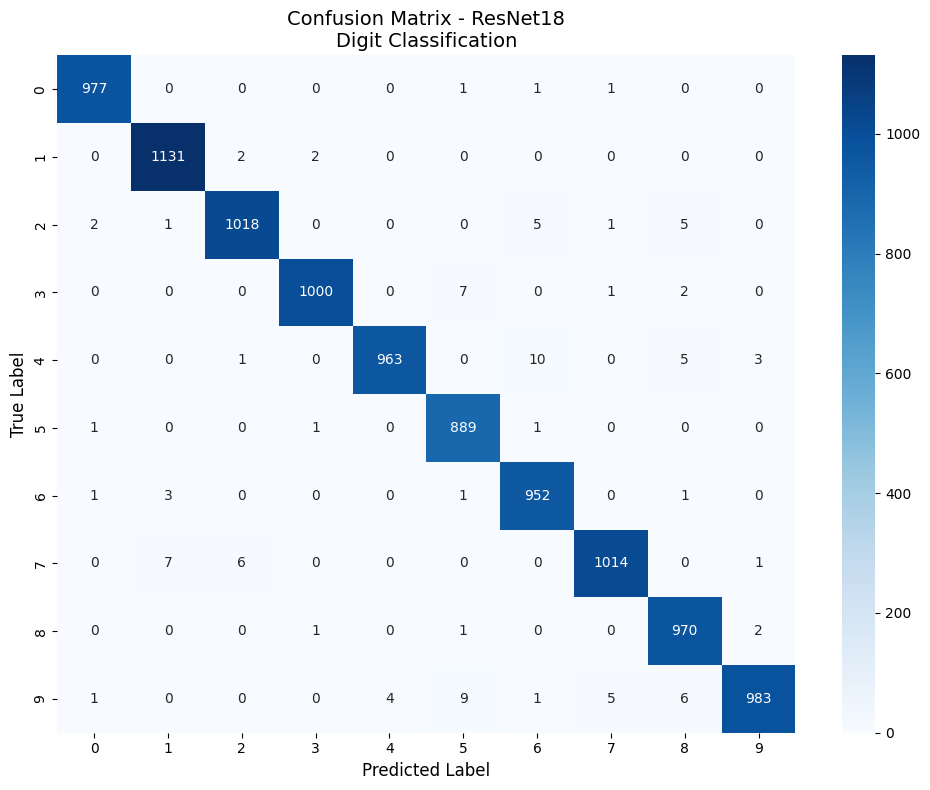

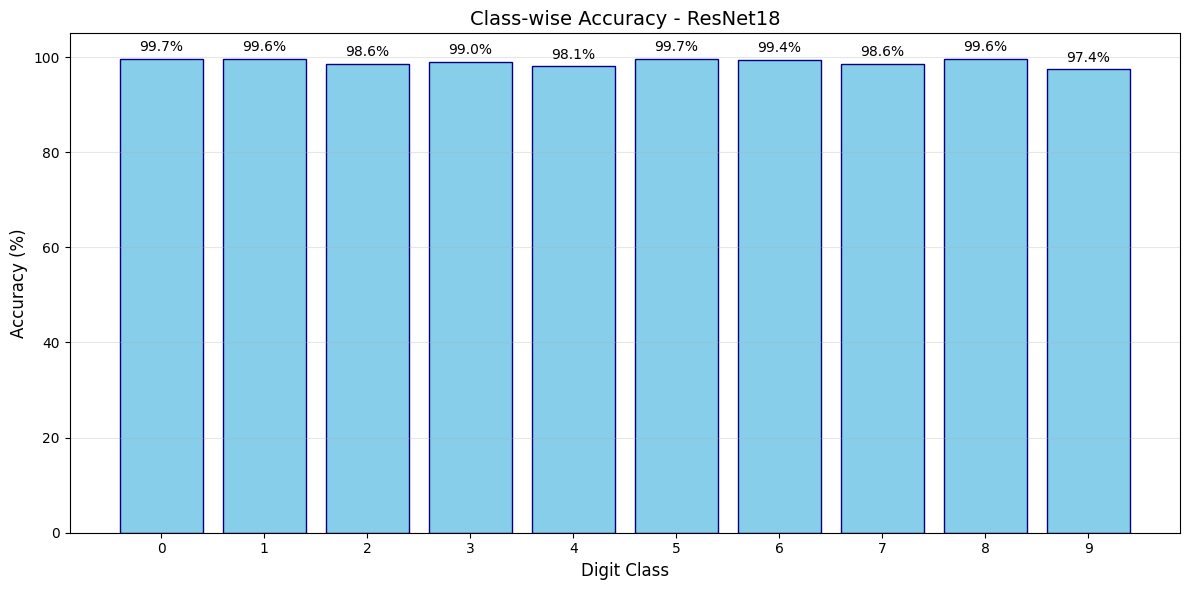

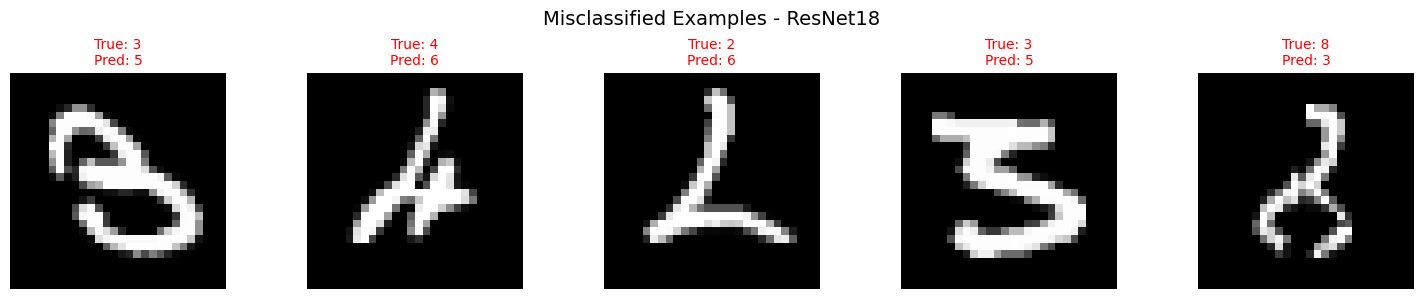


FINAL SUMMARY DASHBOARD


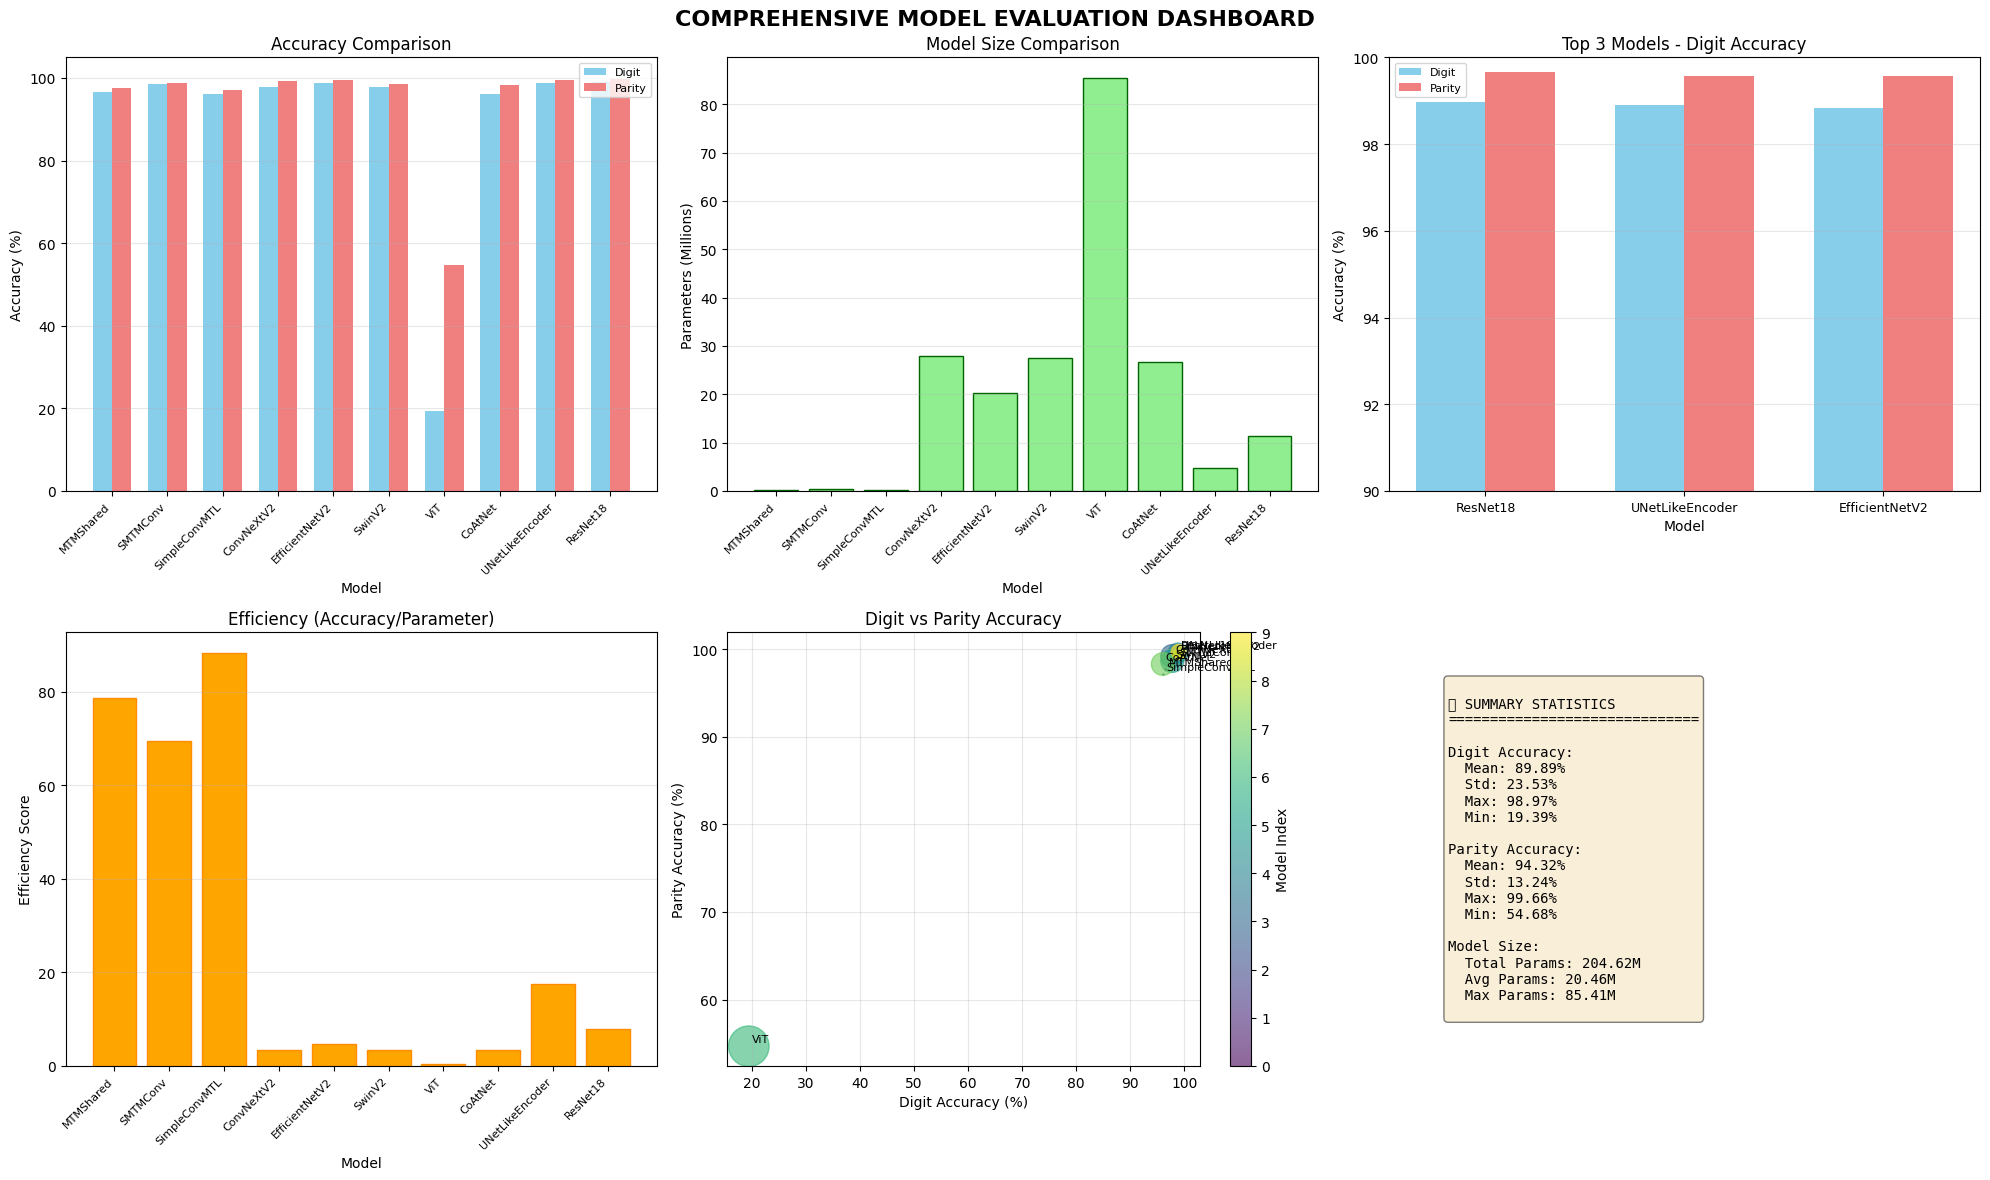


✅ All evaluation plots saved to: ./saved_images
✅ Evaluation completed successfully!


In [2]:
# ==================== EVALUATION METRICS AND PLOTS ====================
# Run this cell after completing the training of all models

print("\n" + "="*60)
print("DETAILED EVALUATION METRICS AND PLOTS")
print("="*60)

# ==================== 1. CONFUSION MATRICES ====================

def plot_confusion_matrix(model, test_loader, model_name, device):
    """Plot confusion matrix for digit classification"""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            digit_pred, _ = model(images)
            preds = digit_pred.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - {model_name}\nDigit Classification', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'confusion_matrix_{model_name}.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return cm

# ==================== 2. CLASS-WISE ACCURACY ====================

def plot_class_wise_accuracy(model, test_loader, model_name, device):
    """Plot accuracy per digit class"""
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            digit_pred, _ = model(images)
            preds = digit_pred.argmax(1)

            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if preds[i].item() == label:
                    class_correct[label] += 1

    class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]

    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(10), class_acc, color='skyblue', edgecolor='navy')

    # Add value labels on bars
    for bar, acc in zip(bars, class_acc):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.xlabel('Digit Class', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title(f'Class-wise Accuracy - {model_name}', fontsize=14)
    plt.xticks(range(10))
    plt.ylim(0, 105)
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'class_accuracy_{model_name}.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return class_acc

# ==================== 3. PERFORMANCE COMPARISON TABLE ====================

def create_performance_summary(model_names, digit_acc, parity_acc):
    """Create detailed performance summary table"""

    # Calculate additional metrics
    avg_digit_acc = np.mean(digit_acc)
    avg_parity_acc = np.mean(parity_acc)

    # Find best and worst models
    best_digit_idx = np.argmax(digit_acc)
    best_parity_idx = np.argmax(parity_acc)

    summary_data = {
        'Model': model_names,
        'Digit Acc (%)': [f'{acc:.2f}' for acc in digit_acc],
        'Parity Acc (%)': [f'{acc:.2f}' for acc in parity_acc],
        'Avg Performance': [f'{(digit_acc[i] + parity_acc[i])/2:.2f}' for i in range(len(model_names))]
    }

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "="*60)
    print("PERFORMANCE SUMMARY TABLE")
    print("="*60)
    print(summary_df.to_string(index=False))

    print("\n" + "="*60)
    print("KEY INSIGHTS")
    print("="*60)
    print(f"📊 Average Digit Accuracy across all models: {avg_digit_acc:.2f}%")
    print(f"📊 Average Parity Accuracy across all models: {avg_parity_acc:.2f}%")
    print(f"🏆 Best Digit Accuracy: {digit_acc[best_digit_idx]:.2f}% ({model_names[best_digit_idx]})")
    print(f"🏆 Best Parity Accuracy: {parity_acc[best_parity_idx]:.2f}% ({model_names[best_parity_idx]})")

    # Find models with balanced performance
    balanced_scores = [(digit_acc[i] + parity_acc[i])/2 - abs(digit_acc[i] - parity_acc[i])/2
                      for i in range(len(model_names))]
    best_balanced_idx = np.argmax(balanced_scores)
    print(f"⚖️ Most Balanced Model: {model_names[best_balanced_idx]} "
          f"(Digit: {digit_acc[best_balanced_idx]:.2f}%, "
          f"Parity: {parity_acc[best_balanced_idx]:.2f}%)")

    return summary_df

# ==================== 4. ERROR ANALYSIS PLOT ====================

def plot_error_analysis(model, test_loader, model_name, device, num_samples=5):
    """Show examples of misclassified digits"""
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            digit_pred, _ = model(images)
            preds = digit_pred.argmax(1)

            # Find misclassified samples
            mis_mask = preds != labels
            mis_indices = torch.where(mis_mask)[0]

            for idx in mis_indices:
                misclassified_images.append(images[idx].cpu())
                misclassified_labels.append(labels[idx].item())
                misclassified_preds.append(preds[idx].item())

                if len(misclassified_images) >= num_samples:
                    break

            if len(misclassified_images) >= num_samples:
                break

    if len(misclassified_images) > 0:
        fig, axes = plt.subplots(1, min(num_samples, len(misclassified_images)),
                                 figsize=(15, 3))
        if min(num_samples, len(misclassified_images)) == 1:
            axes = [axes]

        for i, (img, true_label, pred_label) in enumerate(zip(
                misclassified_images[:num_samples],
                misclassified_labels[:num_samples],
                misclassified_preds[:num_samples])):
            axes[i].imshow(img.squeeze(), cmap='gray')
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}',
                            color='red', fontsize=10)
            axes[i].axis('off')

        plt.suptitle(f'Misclassified Examples - {model_name}', fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'misclassified_{model_name}.png'),
                   dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print(f"No misclassified examples found for {model_name}!")

# ==================== 5. MODEL SIZE COMPARISON ====================

def count_parameters(model):
    """Count trainable parameters in model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_model_size_comparison(models_dict, model_names, device):
    """Compare model sizes (number of parameters)"""
    param_counts = []

    for name in model_names:
        if name in models_dict:
            model = models_dict[name].to(device)
            param_counts.append(count_parameters(model))
        else:
            param_counts.append(0)

    plt.figure(figsize=(14, 6))
    bars = plt.bar(range(len(model_names)), [count/1e6 for count in param_counts],
                   color='lightgreen', edgecolor='darkgreen')

    # Add value labels
    for bar, count in zip(bars, param_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{count/1e6:.2f}M', ha='center', va='bottom', fontsize=9)

    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Number of Parameters (Millions)', fontsize=12)
    plt.title('Model Size Comparison (Trainable Parameters)', fontsize=14)
    plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'model_size_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

    return param_counts

# ==================== 6. RADAR CHART FOR MULTI-METRIC COMPARISON ====================

def plot_radar_chart(model_names, digit_acc, parity_acc, param_counts):
    """Create radar chart comparing models on multiple metrics"""
    from math import pi

    # Normalize metrics
    def normalize(metrics):
        min_val, max_val = min(metrics), max(metrics)
        if max_val - min_val == 0:
            return [0.5] * len(metrics)
        return [(m - min_val) / (max_val - min_val) for m in metrics]

    norm_digit = normalize(digit_acc)
    norm_parity = normalize(parity_acc)
    norm_params = normalize([-p for p in param_counts])  # Negative for smaller is better

    # Select top 5 models for readability
    if len(model_names) > 5:
        # Get indices of top 5 models by average performance
        avg_perf = [(digit_acc[i] + parity_acc[i])/2 for i in range(len(model_names))]
        top_indices = sorted(range(len(avg_perf)), key=lambda i: avg_perf[i], reverse=True)[:5]

        top_names = [model_names[i] for i in top_indices]
        top_digit = [norm_digit[i] for i in top_indices]
        top_parity = [norm_parity[i] for i in top_indices]
        top_params = [norm_params[i] for i in top_indices]
    else:
        top_names = model_names
        top_digit = norm_digit
        top_parity = norm_parity
        top_params = norm_params

    # Number of variables
    N = 3
    categories = ['Digit Accuracy', 'Parity Accuracy', 'Parameter Efficiency']

    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

    # Set angle for each category
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Add each model
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_names)))

    for i, name in enumerate(top_names):
        values = [top_digit[i], top_parity[i], top_params[i]]
        values += values[:1]  # Close the loop

        ax.plot(angles, values, 'o-', linewidth=2, label=name, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])

    # Set category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(['Low', 'Medium', 'High'], fontsize=10)
    ax.set_title('Model Performance Radar Chart\n(Normalized Metrics)', fontsize=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'radar_chart_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()

# ==================== 7. PERFORMANCE vs MODEL SIZE SCATTER PLOT ====================

def plot_performance_vs_size(model_names, digit_acc, parity_acc, param_counts):
    """Scatter plot showing accuracy vs model size"""
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create scatter plot
    scatter = ax.scatter([p/1e6 for p in param_counts], digit_acc,
                        s=100, c='blue', alpha=0.6, label='Digit Accuracy', marker='o')
    ax.scatter([p/1e6 for p in param_counts], parity_acc,
              s=100, c='red', alpha=0.6, label='Parity Accuracy', marker='s')

    # Add model labels
    for i, name in enumerate(model_names):
        ax.annotate(name, (param_counts[i]/1e6 + 0.1, digit_acc[i]),
                   fontsize=8, alpha=0.7)
        ax.annotate(name, (param_counts[i]/1e6 + 0.1, parity_acc[i]),
                   fontsize=8, alpha=0.7)

    ax.set_xlabel('Model Size (Million Parameters)', fontsize=12)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Model Performance vs Size Trade-off', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Add trend lines
    z_digit = np.polyfit([p/1e6 for p in param_counts], digit_acc, 1)
    p_digit = np.poly1d(z_digit)
    ax.plot(sorted([p/1e6 for p in param_counts]),
            p_digit(sorted([p/1e6 for p in param_counts])),
            'b--', alpha=0.5, label='Digit Trend')

    z_parity = np.polyfit([p/1e6 for p in param_counts], parity_acc, 1)
    p_parity = np.poly1d(z_parity)
    ax.plot(sorted([p/1e6 for p in param_counts]),
            p_parity(sorted([p/1e6 for p in param_counts])),
            'r--', alpha=0.5, label='Parity Trend')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'performance_vs_size.png'), dpi=150, bbox_inches='tight')
    plt.show()

# ==================== 8. ACCURACY DISTRIBUTION BOX PLOT ====================

def plot_accuracy_distribution(digit_acc, parity_acc, model_names):
    """Box plot showing distribution of accuracies"""
    fig, ax = plt.subplots(figsize=(10, 6))

    data = [digit_acc, parity_acc]
    bp = ax.boxplot(data, labels=['Digit Accuracy', 'Parity Accuracy'],
                   patch_artist=True)

    # Customize box plot
    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Add individual points
    for i, acc in enumerate([digit_acc, parity_acc]):
        x = np.random.normal(i+1, 0.04, size=len(acc))
        ax.scatter(x, acc, alpha=0.6, color='navy', s=30)

    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Distribution of Model Accuracies', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'accuracy_distribution.png'), dpi=150, bbox_inches='tight')
    plt.show()

# ==================== EXECUTE ALL EVALUATIONS ====================

print("\n" + "="*60)
print("GENERATING COMPREHENSIVE EVALUATION PLOTS")
print("="*60)

# 1. Create performance summary table
summary_df = create_performance_summary(model_names, digit_accuracies, parity_accuracies)

# 2. Calculate and plot model sizes
param_counts = plot_model_size_comparison(models, model_names, device)

# 3. Plot performance vs size scatter
plot_performance_vs_size(model_names, digit_accuracies, parity_accuracies, param_counts)

# 4. Plot accuracy distribution
plot_accuracy_distribution(digit_accuracies, parity_accuracies, model_names)

# 5. Plot radar chart (only if we have enough models)
if len(model_names) >= 3:
    plot_radar_chart(model_names, digit_accuracies, parity_accuracies, param_counts)

# 6. Generate detailed plots for each model (optional - can be time consuming)
print("\n" + "="*60)
print("GENERATING DETAILED PLOTS FOR EACH MODEL")
print("="*60)

for name, model in models.items():
    if name in model_names:
        print(f"\n📊 Analyzing {name}...")

        try:
            # Plot confusion matrix
            cm = plot_confusion_matrix(model, test_loader, name, device)

            # Plot class-wise accuracy
            class_acc = plot_class_wise_accuracy(model, test_loader, name, device)

            # Plot error analysis
            plot_error_analysis(model, test_loader, name, device, num_samples=5)

        except Exception as e:
            print(f"  ⚠️ Could not generate all plots for {name}: {str(e)}")

# ==================== 9. FINAL SUMMARY DASHBOARD ====================

print("\n" + "="*60)
print("FINAL SUMMARY DASHBOARD")
print("="*60)

# Create a comprehensive dashboard
fig = plt.figure(figsize=(20, 12))

# 1. Accuracy comparison (subplot 1)
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(model_names))
width = 0.35
rects1 = ax1.bar(x - width/2, digit_accuracies, width, label='Digit', color='skyblue')
rects2 = ax1.bar(x + width/2, parity_accuracies, width, label='Parity', color='lightcoral')
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
ax1.legend(fontsize=8)
ax1.set_ylim(0, 105)
ax1.grid(True, axis='y', alpha=0.3)

# 2. Model size comparison (subplot 2)
ax2 = plt.subplot(2, 3, 2)
param_counts_mil = [p/1e6 for p in param_counts]
bars2 = ax2.bar(range(len(model_names)), param_counts_mil, color='lightgreen', edgecolor='darkgreen')
ax2.set_xlabel('Model')
ax2.set_ylabel('Parameters (Millions)')
ax2.set_title('Model Size Comparison')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
ax2.grid(True, axis='y', alpha=0.3)

# 3. Top 3 models by digit accuracy (subplot 3)
ax3 = plt.subplot(2, 3, 3)
top3_indices = np.argsort(digit_accuracies)[-3:][::-1]
top3_names = [model_names[i] for i in top3_indices]
top3_digit = [digit_accuracies[i] for i in top3_indices]
top3_parity = [parity_accuracies[i] for i in top3_indices]
x3 = np.arange(len(top3_names))
width3 = 0.35
ax3.bar(x3 - width3/2, top3_digit, width3, label='Digit', color='skyblue')
ax3.bar(x3 + width3/2, top3_parity, width3, label='Parity', color='lightcoral')
ax3.set_xlabel('Model')
ax3.set_ylabel('Accuracy (%)')
ax3.set_title('Top 3 Models - Digit Accuracy')
ax3.set_xticks(x3)
ax3.set_xticklabels(top3_names, fontsize=9)
ax3.legend(fontsize=8)
ax3.set_ylim(90, 100)
ax3.grid(True, axis='y', alpha=0.3)

# 4. Efficiency score (Accuracy/Parameter ratio) (subplot 4)
ax4 = plt.subplot(2, 3, 4)
efficiency_scores = [(digit_accuracies[i] + parity_accuracies[i])/2 / (param_counts[i]/1e6 + 1)
                     for i in range(len(model_names))]
bars4 = ax4.bar(range(len(model_names)), efficiency_scores, color='orange', edgecolor='darkorange')
ax4.set_xlabel('Model')
ax4.set_ylabel('Efficiency Score')
ax4.set_title('Efficiency (Accuracy/Parameter)')
ax4.set_xticks(range(len(model_names)))
ax4.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
ax4.grid(True, axis='y', alpha=0.3)

# 5. Parity vs Digit scatter (subplot 5)
ax5 = plt.subplot(2, 3, 5)
scatter = ax5.scatter(digit_accuracies, parity_accuracies,
                      s=[p/1e5 for p in param_counts], alpha=0.6, c=range(len(model_names)), cmap='viridis')
for i, name in enumerate(model_names):
    ax5.annotate(name, (digit_accuracies[i] + 0.5, parity_accuracies[i] + 0.5), fontsize=8)
ax5.set_xlabel('Digit Accuracy (%)')
ax5.set_ylabel('Parity Accuracy (%)')
ax5.set_title('Digit vs Parity Accuracy')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, label='Model Index')

# 6. Summary statistics (subplot 6)
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
stats_text = f"""
📊 SUMMARY STATISTICS
{'='*30}

Digit Accuracy:
  Mean: {np.mean(digit_accuracies):.2f}%
  Std: {np.std(digit_accuracies):.2f}%
  Max: {np.max(digit_accuracies):.2f}%
  Min: {np.min(digit_accuracies):.2f}%

Parity Accuracy:
  Mean: {np.mean(parity_accuracies):.2f}%
  Std: {np.std(parity_accuracies):.2f}%
  Max: {np.max(parity_accuracies):.2f}%
  Min: {np.min(parity_accuracies):.2f}%

Model Size:
  Total Params: {sum(param_counts)/1e6:.2f}M
  Avg Params: {np.mean(param_counts)/1e6:.2f}M
  Max Params: {np.max(param_counts)/1e6:.2f}M
"""
ax6.text(0.1, 0.5, stats_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('COMPREHENSIVE MODEL EVALUATION DASHBOARD', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'complete_evaluation_dashboard.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ All evaluation plots saved to: {save_dir}")
print("✅ Evaluation completed successfully!")

In [3]:
# ==================== COMPRESS ALL OUTPUTS FOR DOWNLOAD ====================
# Run this cell at the end to create a zip file of all results

# Working Directory/Folder
save_dir = './saved_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Directory '{save_dir}' created successfully.")
else:
    print(f"Directory '{save_dir}' already exists.")


import zipfile
import os
import datetime

def compress_results(save_dir='./saved_images', output_filename=None):
    """
    Compress all saved images and results into a single zip file
    """

    # Create output filename with timestamp
    if output_filename is None:
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        output_filename = f'mnist_comparison_results_{timestamp}.zip'

    # Files and directories to include
    items_to_zip = [
        save_dir,  # All saved images
        'MNIST_DL_Architectural_Comparison.ipynb',  # The notebook itself
    ]

    # Also save the results DataFrame as CSV
    if 'df_accuracies' in globals():
        df_accuracies.to_csv(os.path.join(save_dir, 'accuracy_results.csv'), index=False)
        print("✅ Saved accuracy results to CSV")

    # Save model accuracies as text file
    if 'model_names' in globals() and 'digit_accuracies' in globals() and 'parity_accuracies' in globals():
        with open(os.path.join(save_dir, 'accuracy_summary.txt'), 'w') as f:
            f.write("MNIST Multi-Task Learning Model Comparison\n")
            f.write("="*50 + "\n\n")
            f.write(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Device: {device}\n\n")
            f.write("-"*50 + "\n")
            f.write(f"{'Model':<25} {'Digit Acc':<12} {'Parity Acc':<12}\n")
            f.write("-"*50 + "\n")
            for name, dig, par in zip(model_names, digit_accuracies, parity_accuracies):
                f.write(f"{name:<25} {dig:>10.2f}% {par:>10.2f}%\n")
            f.write("-"*50 + "\n")
            f.write(f"\nAverage Digit Accuracy: {np.mean(digit_accuracies):.2f}%")
            f.write(f"\nAverage Parity Accuracy: {np.mean(parity_accuracies):.2f}%")
        print("✅ Saved accuracy summary to text file")

    # Create zip file
    print(f"\n📦 Creating zip file: {output_filename}")

    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:

        # Add the saved_images directory contents
        if os.path.exists(save_dir):
            for root, dirs, files in os.walk(save_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, os.path.dirname(save_dir))
                    zipf.write(file_path, arcname)
                    print(f"  Added: {arcname}")

        # Add the notebook file if it exists
        notebook_file = 'MNIST_DL_Architectural_Comparison.ipynb'
        if os.path.exists(notebook_file):
            zipf.write(notebook_file, notebook_file)
            print(f"  Added: {notebook_file}")

        # Add a README file with experiment details
        readme_content = f"""
MNIST Multi-Task Learning Architecture Comparison
=================================================
Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Device: {device}

Experiment Details:
------------------
- Dataset: MNIST (28x28 grayscale images)
- Tasks: Digit Classification (10 classes) + Parity Classification (Even/Odd)
- Number of Models: {len(model_names) if 'model_names' in globals() else 'N/A'}
- Training Epochs per Model: 2
- Batch Size: 64
- Optimizer: Adam (lr=0.001)

Models Evaluated:
----------------
{chr(10).join([f"- {name}" for name in model_names]) if 'model_names' in globals() else 'N/A'}

Results Summary:
---------------
{df_accuracies.to_string(index=False) if 'df_accuracies' in globals() else 'N/A'}

Files Included:
--------------
- *.png: Visualization plots and comparison charts
- accuracy_results.csv: Detailed accuracy results
- accuracy_summary.txt: Text summary of results
- MNIST_DL_Architectural_Comparison.ipynb: Original notebook

Created by: MNIST DL Architecture Comparison Script
        """

        readme_path = os.path.join(save_dir, 'README.txt')
        with open(readme_path, 'w') as f:
            f.write(readme_content)
        zipf.write(readme_path, 'README.txt')
        print("  Added: README.txt")

    print(f"\n✅ Successfully created {output_filename}")
    print(f"📁 File size: {os.path.getsize(output_filename) / (1024*1024):.2f} MB")

    return output_filename

# ==================== CREATE MINIFIED NOTEBOOK VERSION ====================

def create_minified_notebook(original_notebook='MNIST_DL_Architectural_Comparison.ipynb'):
    """
    Create a compressed/minified version of the notebook (removes outputs)
    """
    import json

    if not os.path.exists(original_notebook):
        print(f"⚠️  Notebook {original_notebook} not found")
        return

    with open(original_notebook, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    # Clear all outputs to reduce file size
    for cell in notebook['cells']:
        if 'outputs' in cell:
            cell['outputs'] = []
        if 'execution_count' in cell:
            cell['execution_count'] = None

    # Save minified version
    minified_name = 'MNIST_Comparison_MINIFIED.ipynb'
    with open(minified_name, 'w', encoding='utf-8') as f:
        json.dump(notebook, f, indent=1)  # Minimal indentation

    original_size = os.path.getsize(original_notebook) / 1024
    minified_size = os.path.getsize(minified_name) / 1024

    print(f"\n📄 Notebook minification complete:")
    print(f"   Original: {original_size:.1f} KB")
    print(f"   Minified: {minified_size:.1f} KB")
    print(f"   Reduction: {(1 - minified_size/original_size)*100:.1f}%")

    return minified_name

# ==================== GENERATE HTML REPORT ====================

def generate_html_report(save_dir='./saved_images'):
    """
    Generate an HTML report summarizing all results
    """
    html_content = f"""
<!DOCTYPE html>
<html>
<head>
    <title>MNIST Multi-Task Learning Comparison</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #f5f5f5; }}
        .container {{ max-width: 1200px; margin: auto; background: white; padding: 20px; border-radius: 10px; box-shadow: 0 0 10px rgba(0,0,0,0.1); }}
        h1, h2 {{ color: #333; }}
        table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #4CAF50; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
        .plot-container {{ margin: 30px 0; text-align: center; }}
        .plot {{ max-width: 100%; border: 1px solid #ddd; border-radius: 5px; }}
        .summary {{ background-color: #e7f3fe; padding: 15px; border-left: 6px solid #2196F3; margin: 20px 0; }}
        .footer {{ text-align: center; margin-top: 30px; color: #777; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>📊 MNIST Multi-Task Learning Architecture Comparison</h1>
        <p>Generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>

        <div class="summary">
            <h2>Experiment Summary</h2>
            <p><strong>Dataset:</strong> MNIST (28x28 grayscale images)</p>
            <p><strong>Tasks:</strong> Digit Classification (10 classes) + Parity Classification (Even/Odd)</p>
            <p><strong>Number of Models:</strong> {len(model_names) if 'model_names' in globals() else 'N/A'}</p>
            <p><strong>Device:</strong> {device}</p>
        </div>

        <h2>Results Table</h2>
        {df_accuracies.to_html(index=False) if 'df_accuracies' in globals() else '<p>No results available</p>'}

        <h2>Visualizations</h2>
        <div class="plot-container">
            <h3>Model Accuracy Comparison</h3>
            <img class="plot" src="model_accuracy_comparison.png" alt="Accuracy Comparison">
        </div>
"""

    # Add individual model plots if they exist
    if os.path.exists(save_dir):
        for file in os.listdir(save_dir):
            if file.startswith('confusion_matrix_') and file.endswith('.png'):
                model_name = file.replace('confusion_matrix_', '').replace('.png', '')
                html_content += f"""
        <div class="plot-container">
            <h3>Confusion Matrix - {model_name}</h3>
            <img class="plot" src="{file}" alt="Confusion Matrix {model_name}">
        </div>
"""

    html_content += """
        <div class="footer">
            <p>Generated by MNIST DL Architecture Comparison Script</p>
        </div>
    </div>
</body>
</html>
    """

    # Save HTML report
    report_path = os.path.join(save_dir, 'report.html')
    with open(report_path, 'w') as f:
        f.write(html_content)

    print(f"✅ HTML report generated: {report_path}")
    return report_path

# ==================== EXECUTE COMPRESSION ====================

print("\n" + "="*60)
print("📦 COMPRESSING RESULTS FOR DOWNLOAD")
print("="*60)

# Generate HTML report
try:
    report_path = generate_html_report(save_dir)
except Exception as e:
    print(f"⚠️  Could not generate HTML report: {e}")

# Create minified notebook version
try:
    minified_notebook = create_minified_notebook()
except Exception as e:
    print(f"⚠️  Could not create minified notebook: {e}")

# Create zip file
try:
    zip_filename = compress_results(save_dir)
    print(f"\n✅ Ready for download! File: {zip_filename}")

    # If in Google Colab, provide download link
    try:
        from google.colab import files
        print("\n📥 Downloading zip file...")
        files.download(zip_filename)
        print("✅ Download started!")
    except:
        print("\n📁 To download manually:")
        print(f"   - Locate the file: {zip_filename}")
        print(f"   - Right-click and select 'Download'")

except Exception as e:
    print(f"❌ Error during compression: {e}")

print("\n" + "="*60)
print("✅ ALL DONE! All results have been saved and compressed.")
print("="*60)

Directory './saved_images' already exists.

📦 COMPRESSING RESULTS FOR DOWNLOAD
⚠️  Could not generate HTML report: name 'device' is not defined
⚠️  Notebook MNIST_DL_Architectural_Comparison.ipynb not found

📦 Creating zip file: mnist_comparison_results_20260222_123600.zip
❌ Error during compression: name 'device' is not defined

✅ ALL DONE! All results have been saved and compressed.
